In [13]:
import os
import numpy as np
import scipy.io
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from geneticalgorithm import geneticalgorithm as ga
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
import h5py


In [14]:
# Define the 1st function
def transfer_function(x, a, b, c):
    return a * (1 - np.exp(-x / b)) + c
# Define the 2nd function
def gompertz_function(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))
# Define the 3rd function

# Define function to load MATLAB file with nested structs
def load_matlab_struct(file_path, struct_path):
    """
    Args:
        file_path (str): The path to the .mat file.
        struct_path (str): The path to the struct in the .mat file, using dot notation to specify nested structs.

    Returns:
        A dictionary containing the struct fields and values.
    """
    # Load the data from the .mat file
    with h5py.File(file_path, 'r') as file:
        struct_data = file[struct_path]
    # Convert the nested structs to dictionaries
        if isinstance(struct_data, h5py.Group):
            struct_data = _convert_h5py_group(struct_data)

    return struct_data

def _convert_h5py_group(group):
    """
    Recursively converts an h5py Group object to a dictionary.
    """
    dict_ = {}
    for key, val in group.items():
        if isinstance(val, h5py.Group):
            dict_[key] = _convert_h5py_group(val)
        else:
            dict_[key] = val[()]
    return dict_

Now is processing:  /Users/xinyaoyo/MATLAB/Projects/UROP/Codes/single_subject_dataset/Pat0905_00_chan11


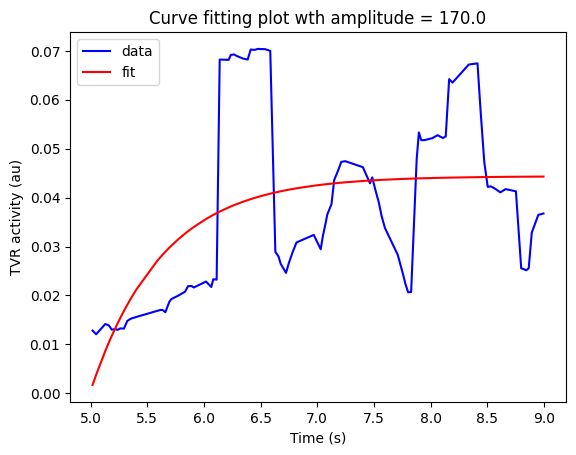

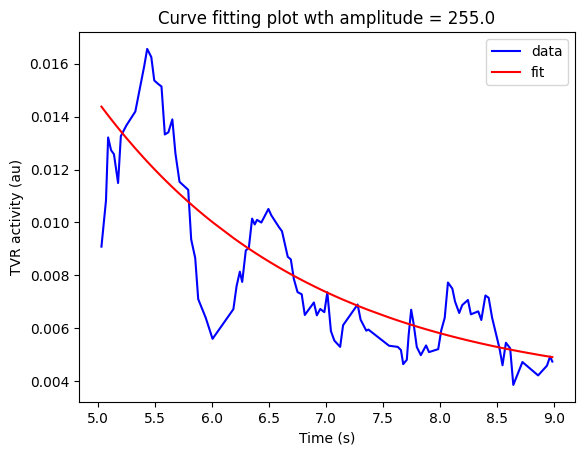

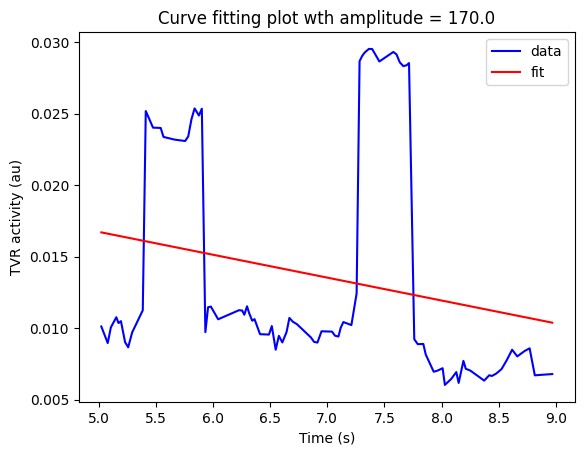

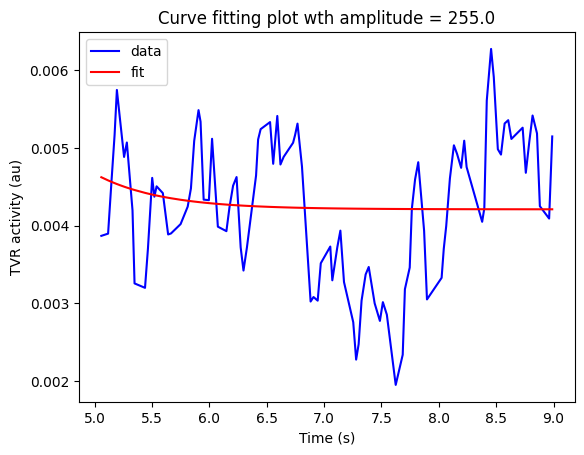

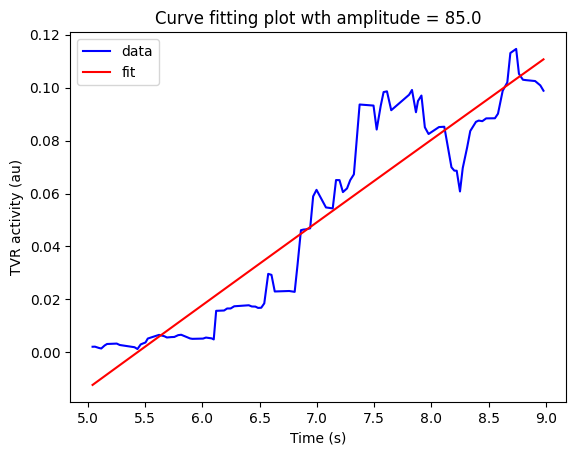

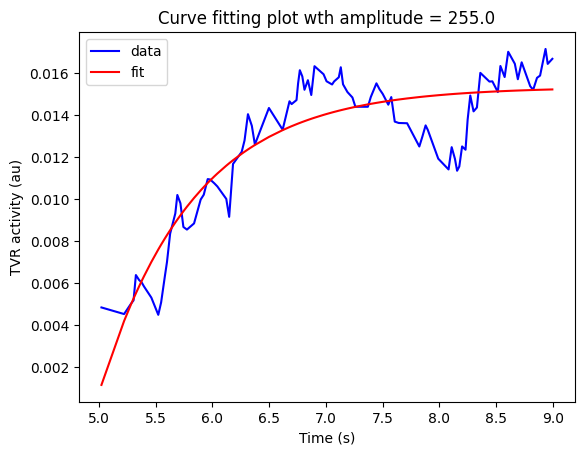

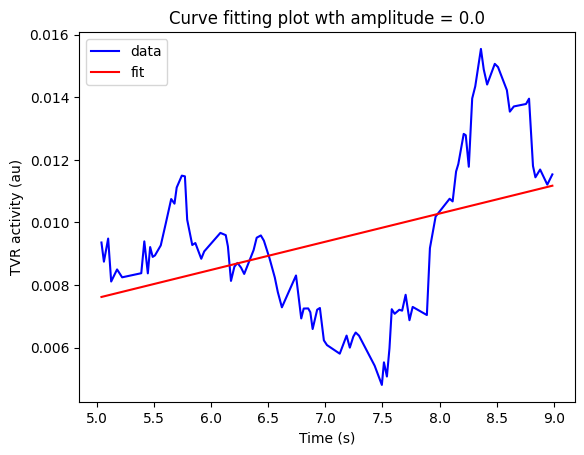

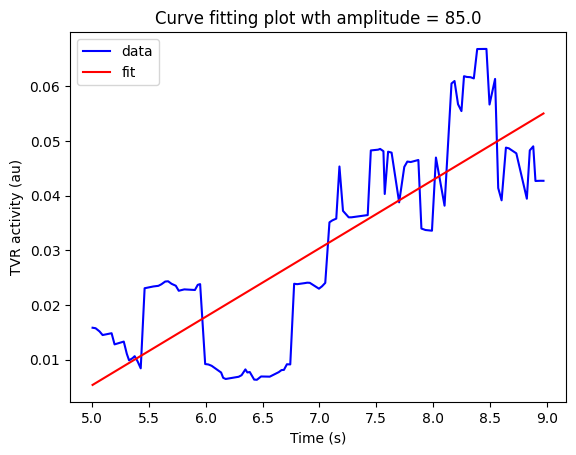

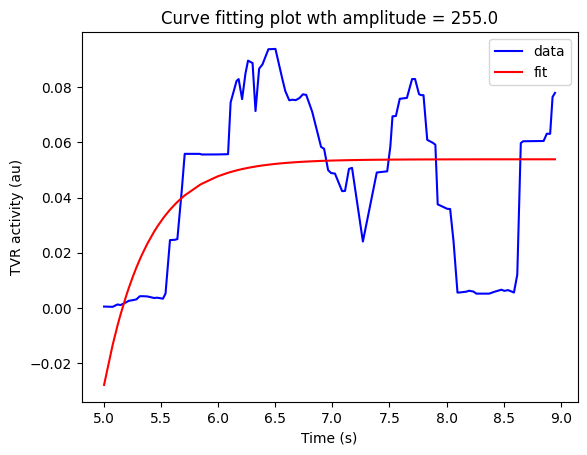

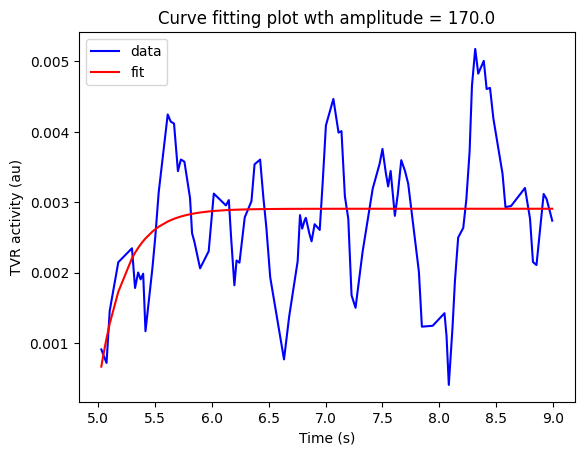

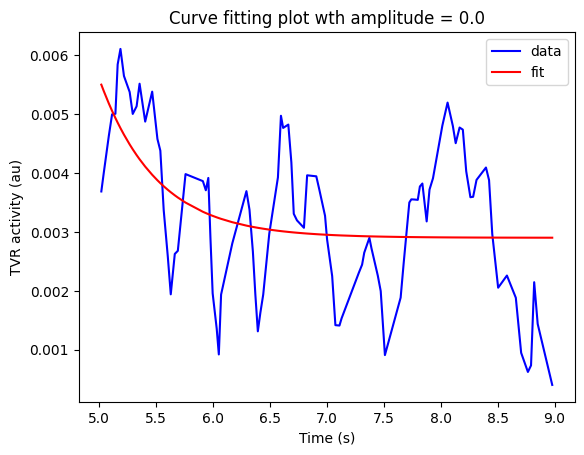

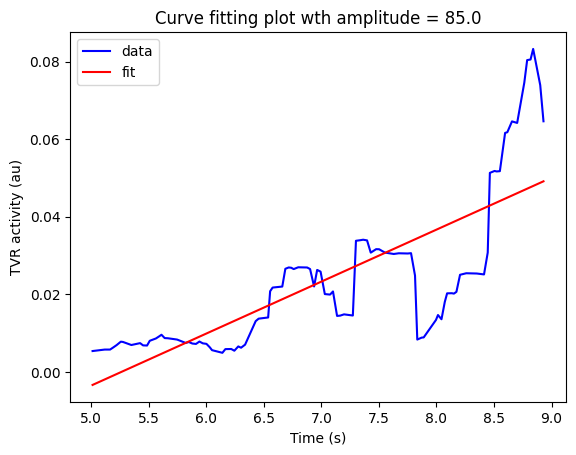

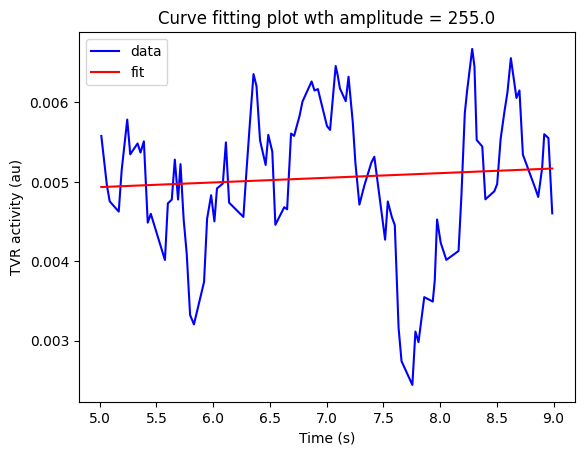

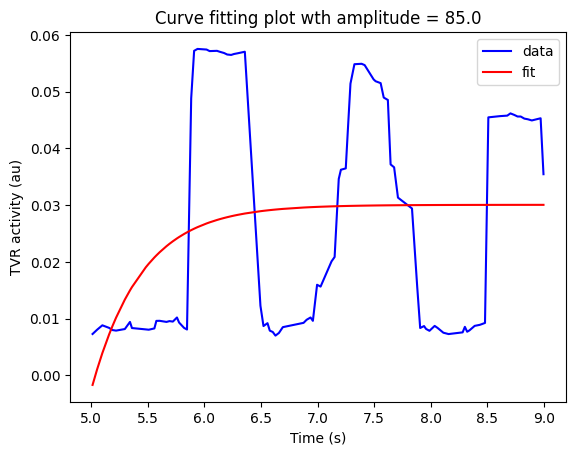

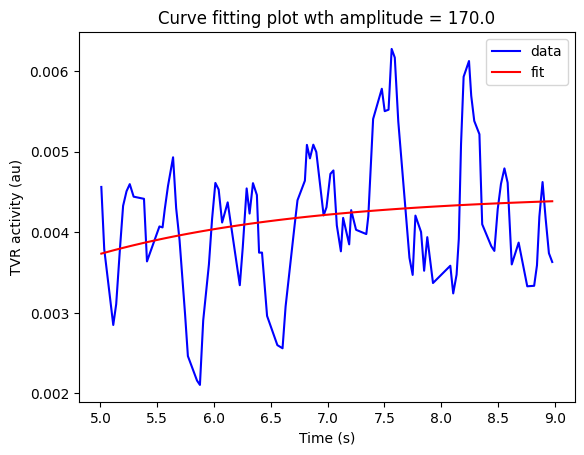

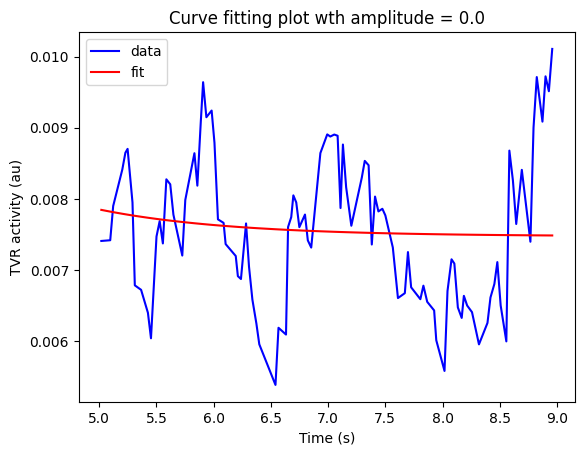

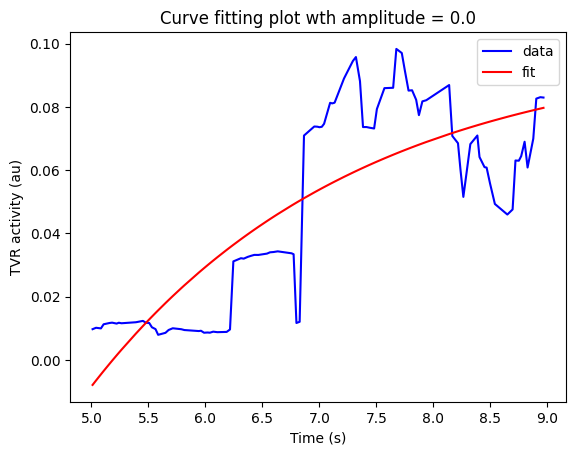

Now is processing:  /Users/xinyaoyo/MATLAB/Projects/UROP/Codes/single_subject_dataset/Pat0905_10_chan11


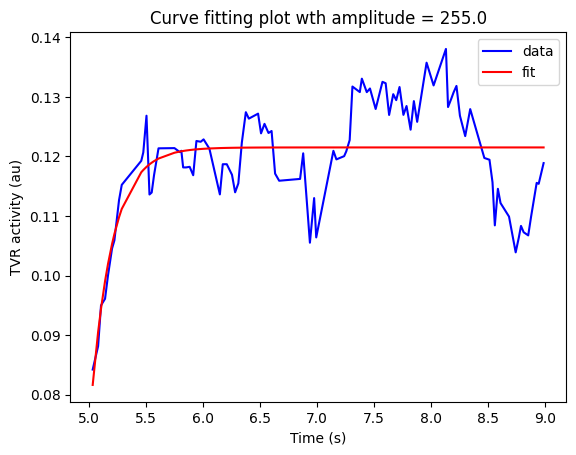

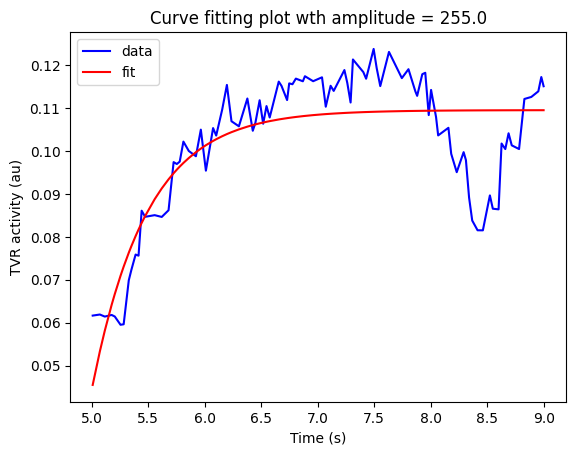

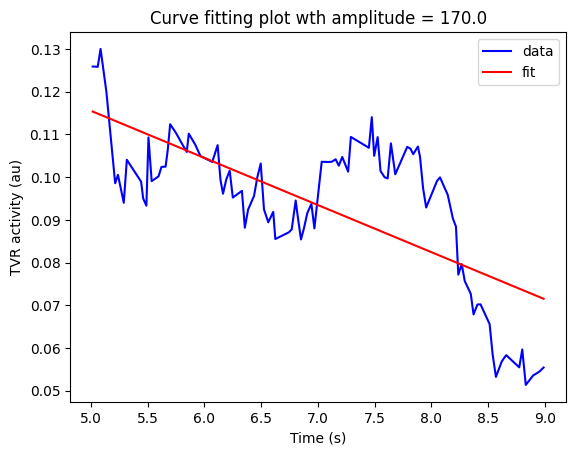

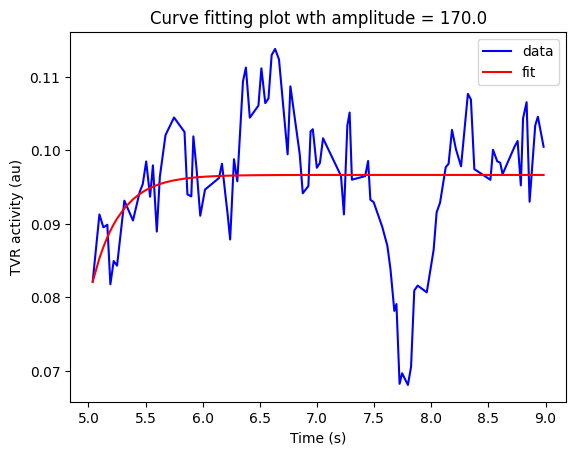

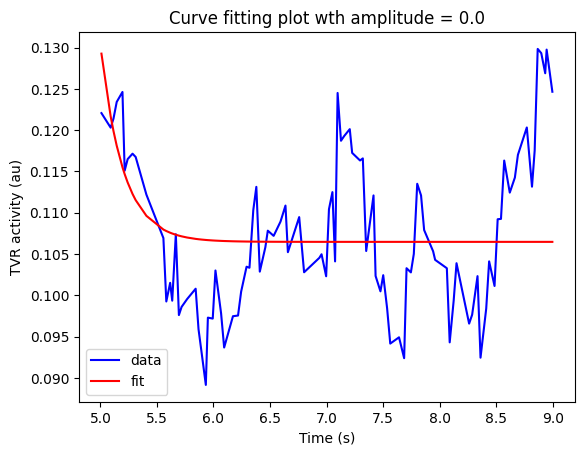

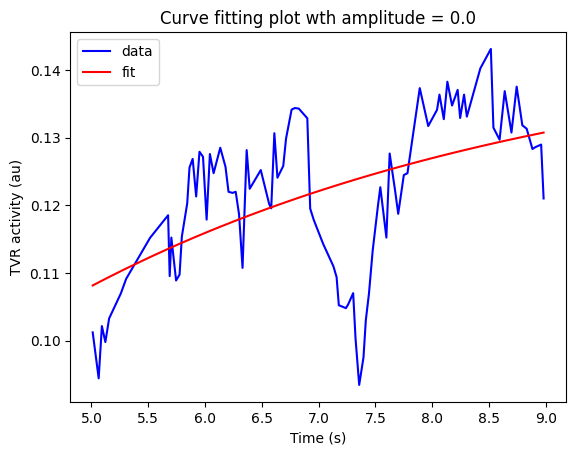

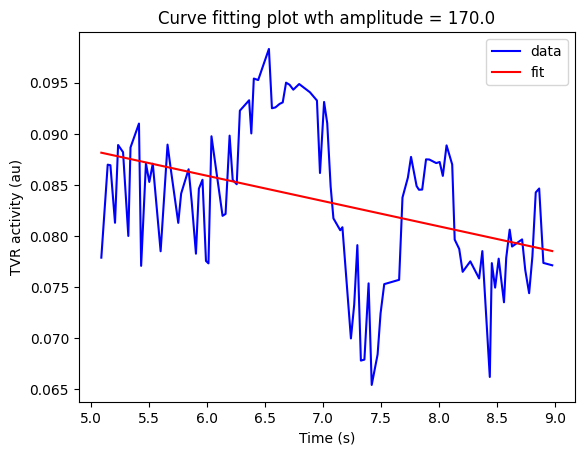

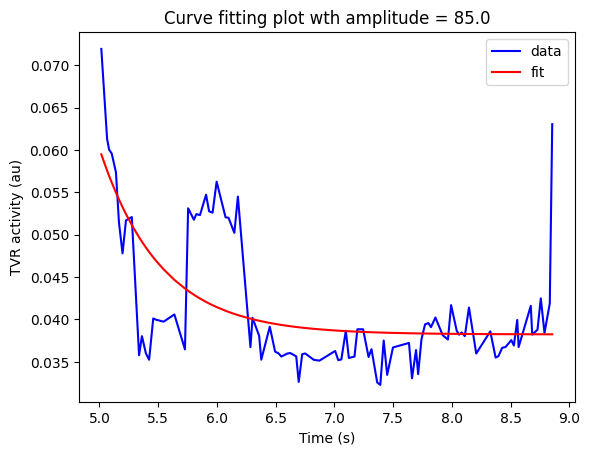

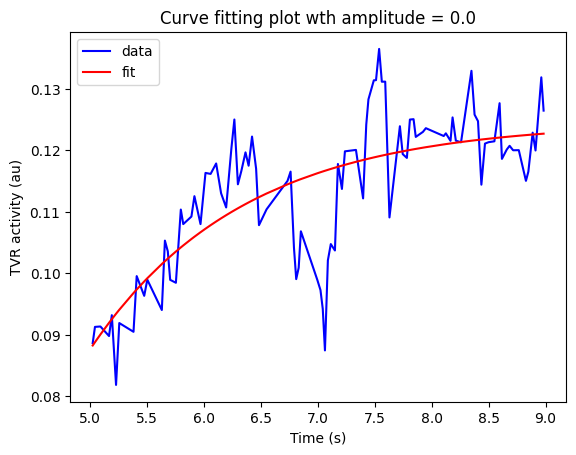

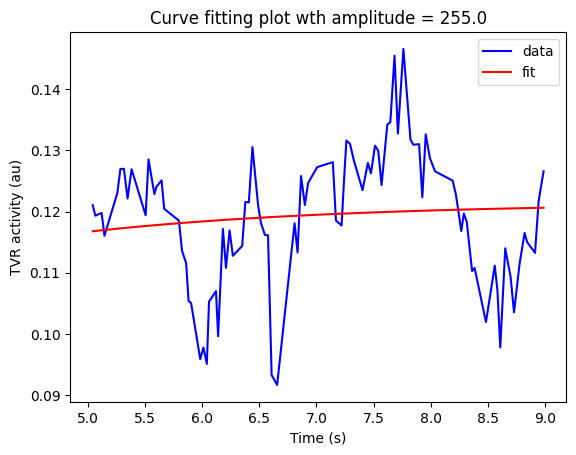

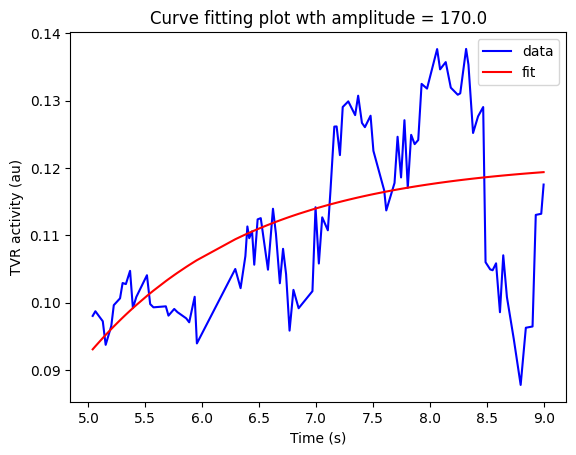

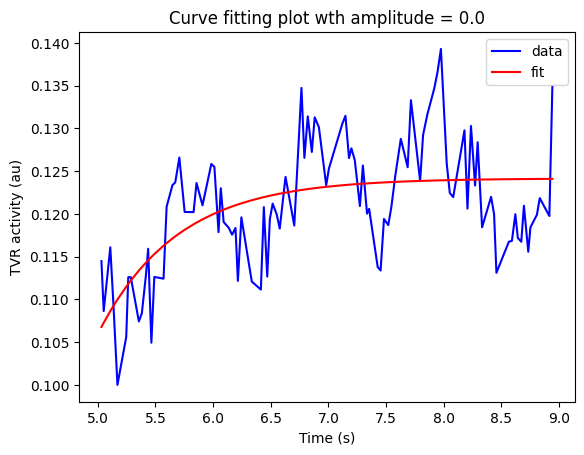

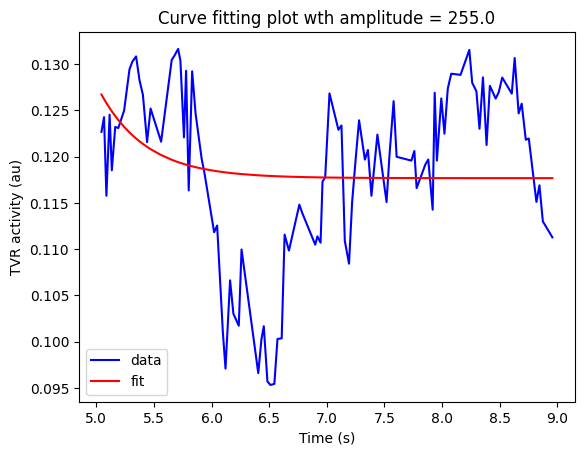

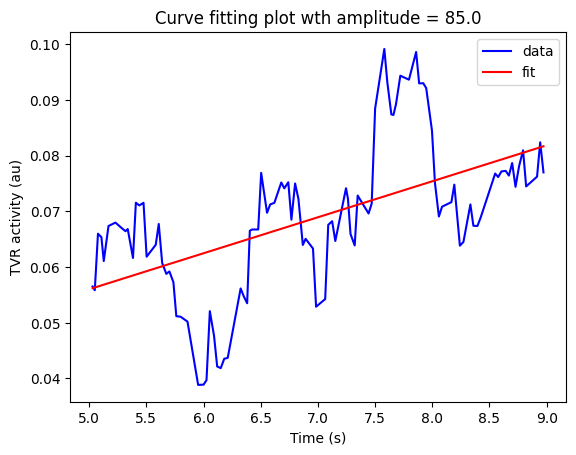

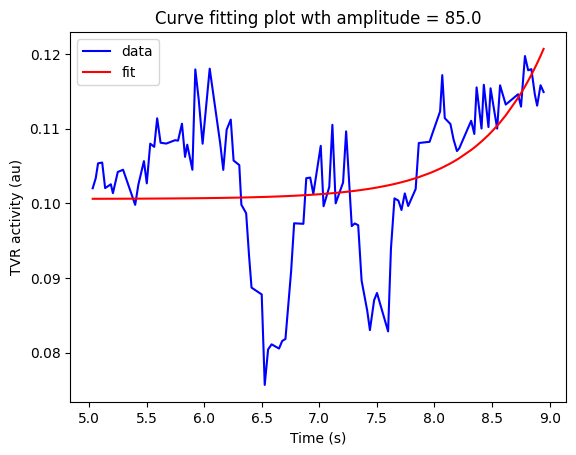

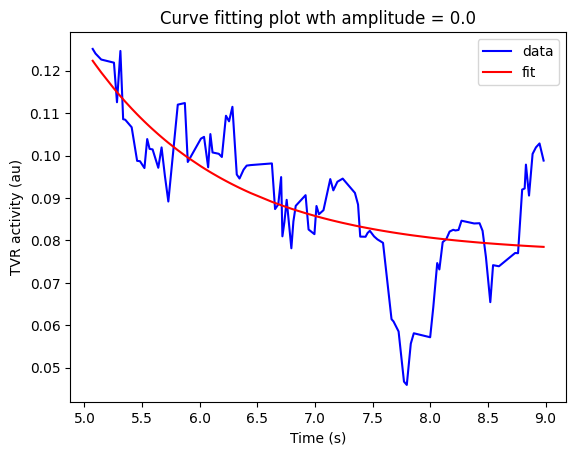

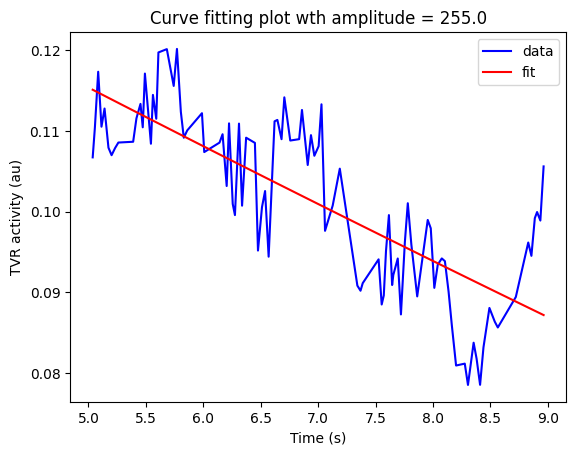

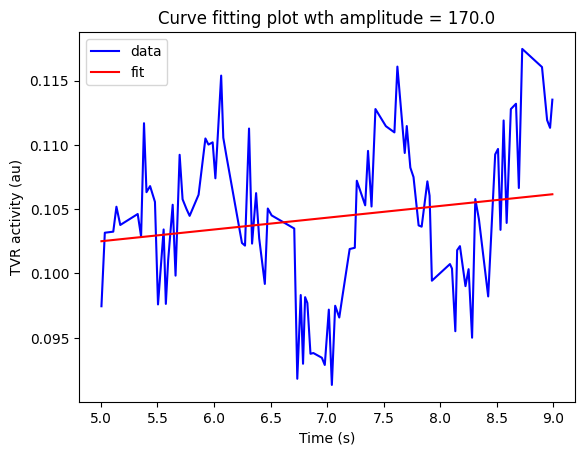

Now is processing:  /Users/xinyaoyo/MATLAB/Projects/UROP/Codes/single_subject_dataset/pat1130_10_chan4


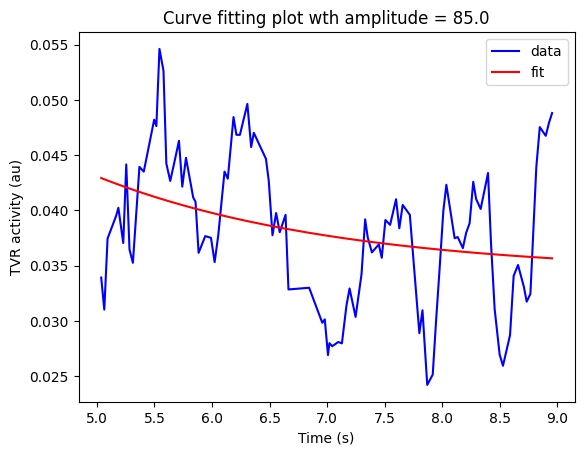

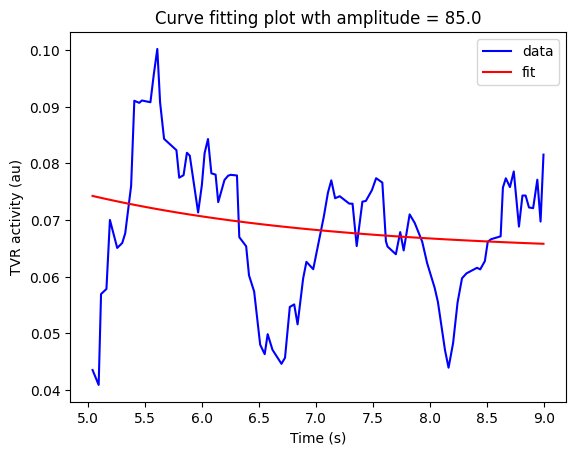

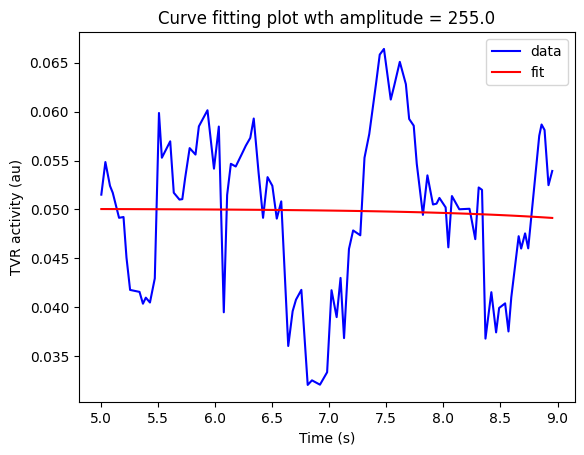

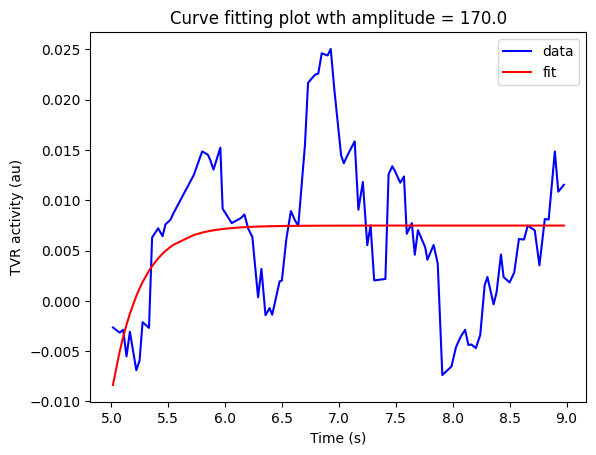

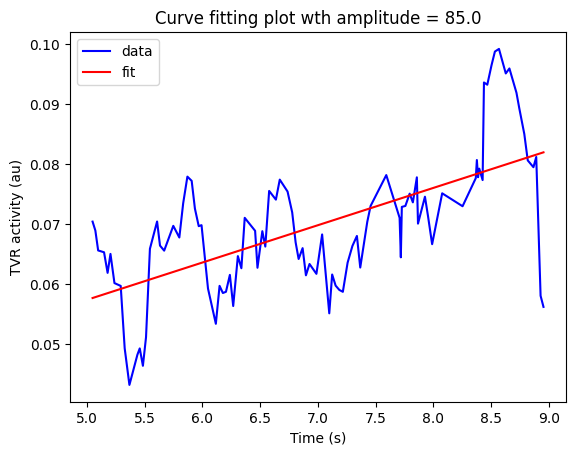

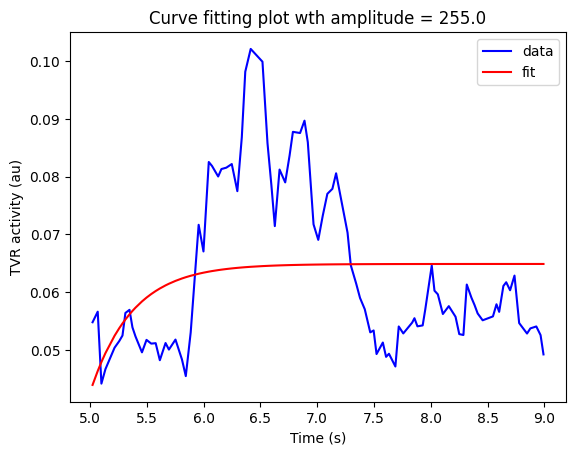

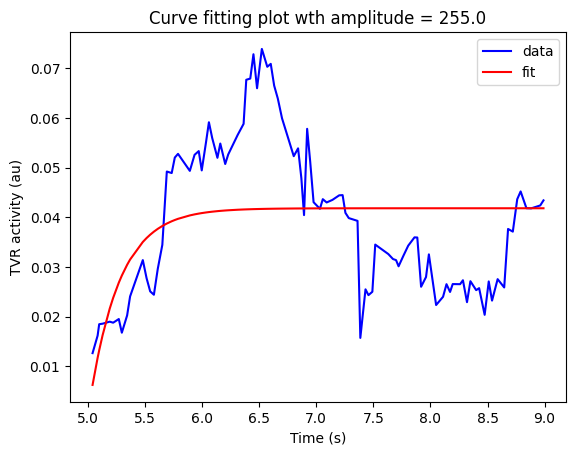

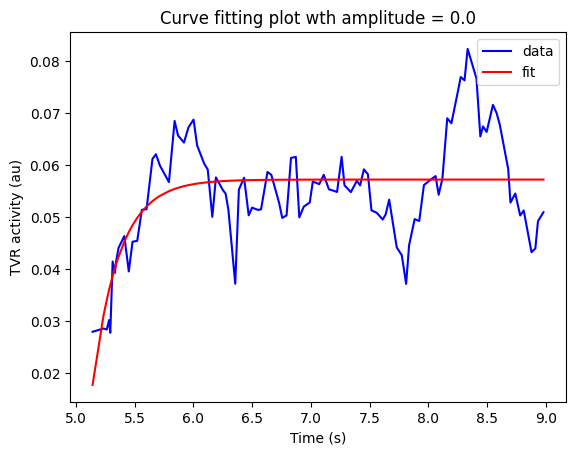

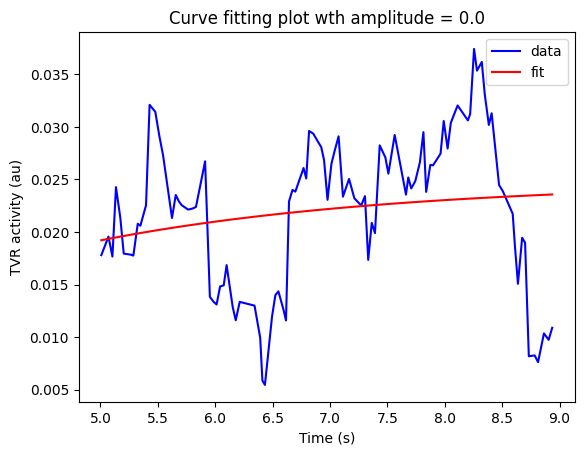

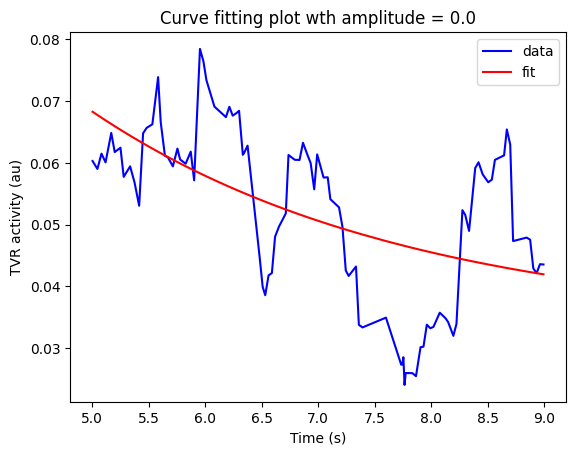

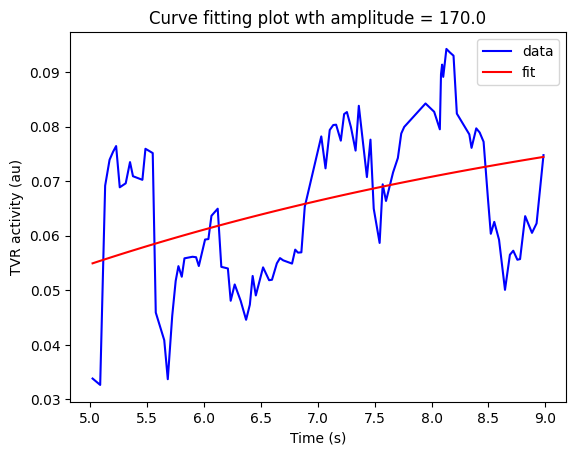

Now is processing:  /Users/xinyaoyo/MATLAB/Projects/UROP/Codes/single_subject_dataset/pat1121_10_chan4


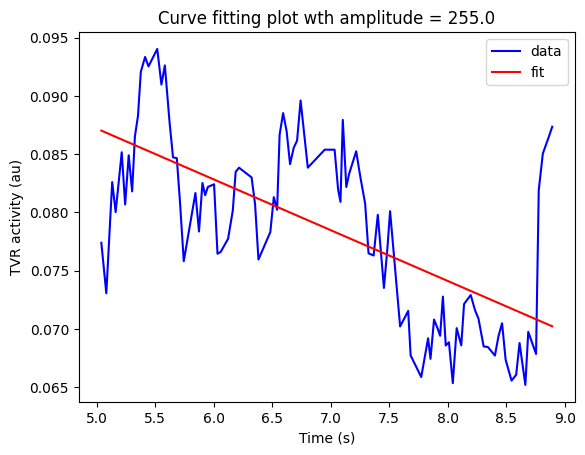

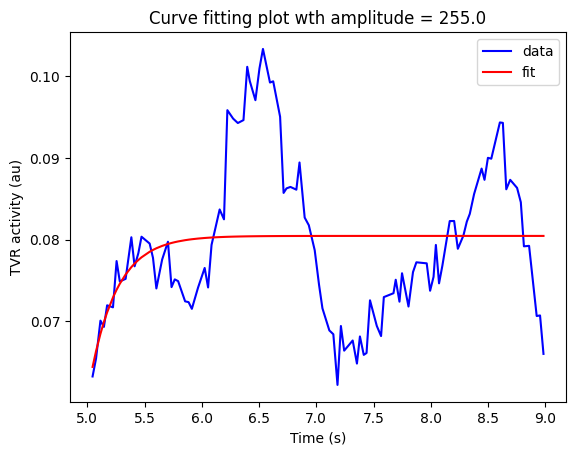

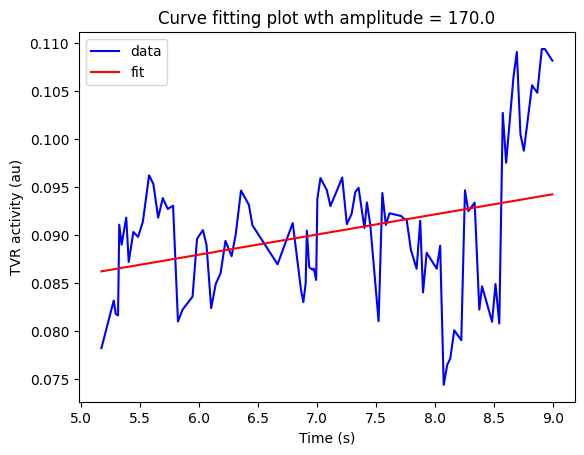

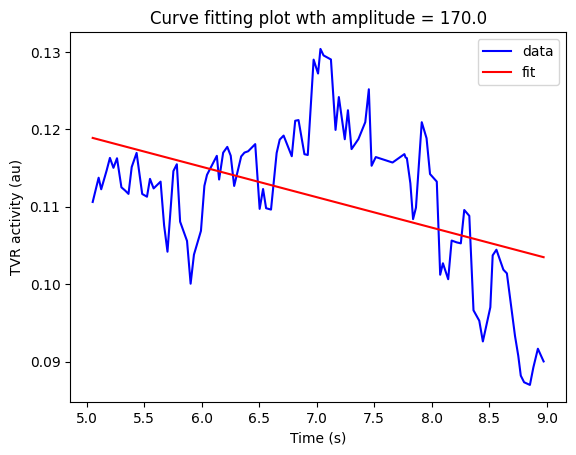

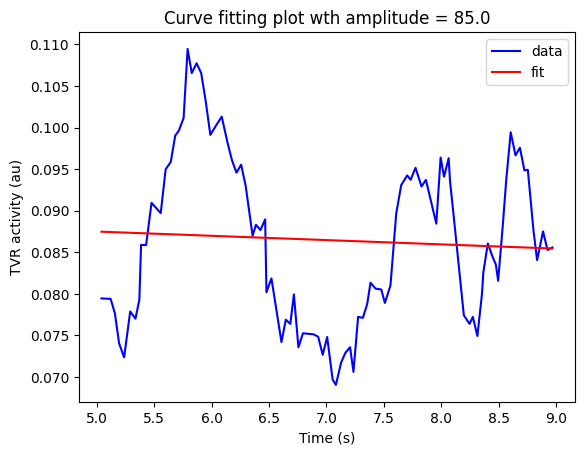

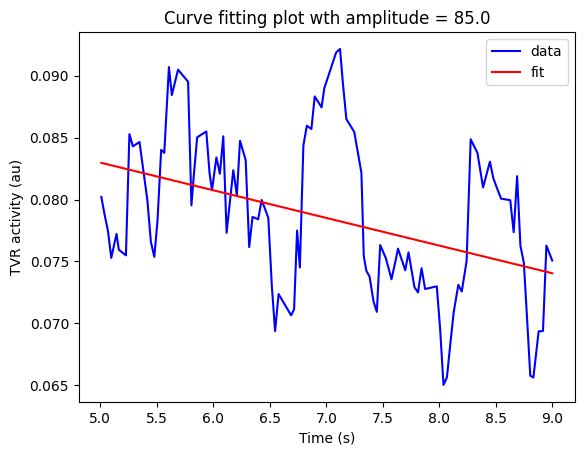

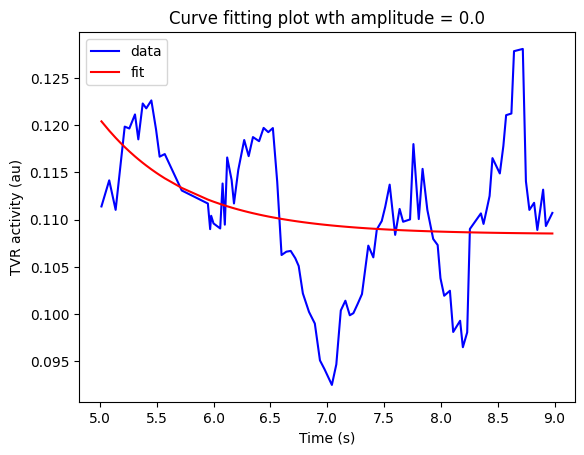

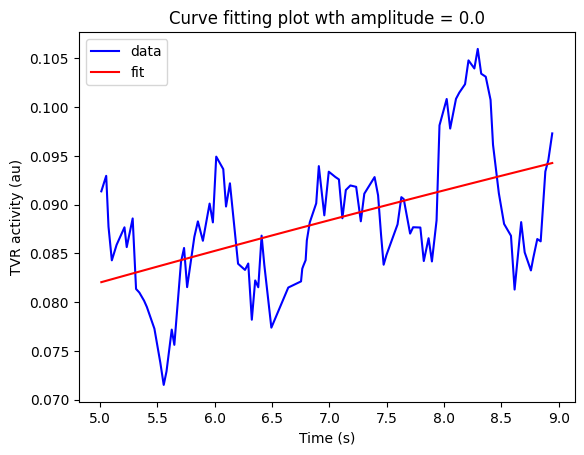

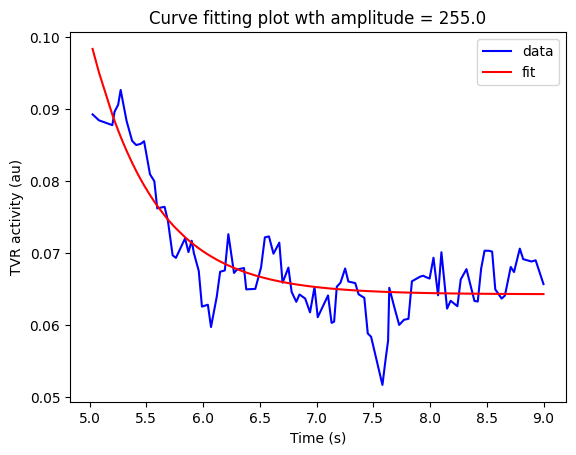

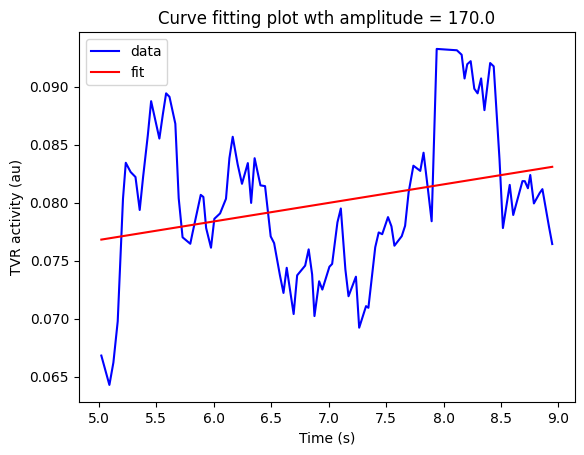

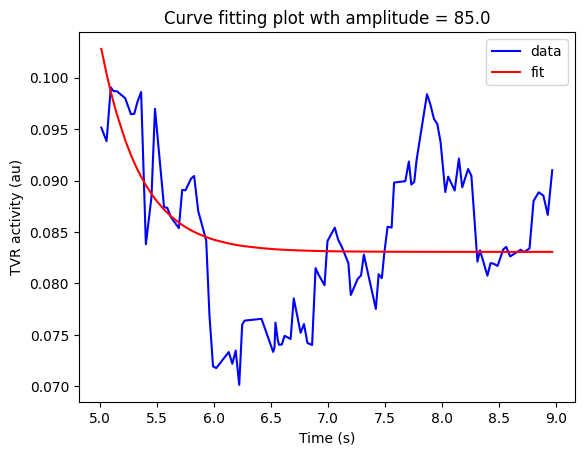

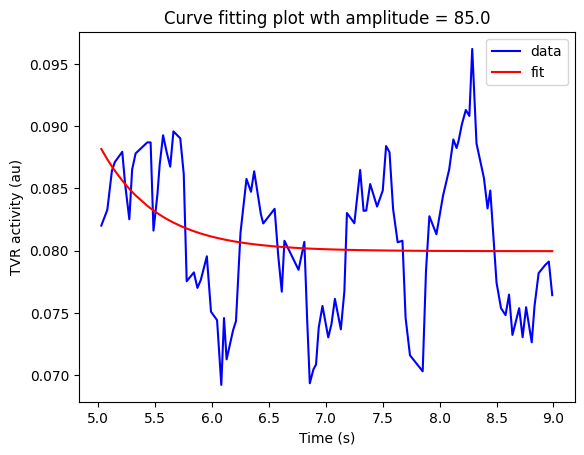

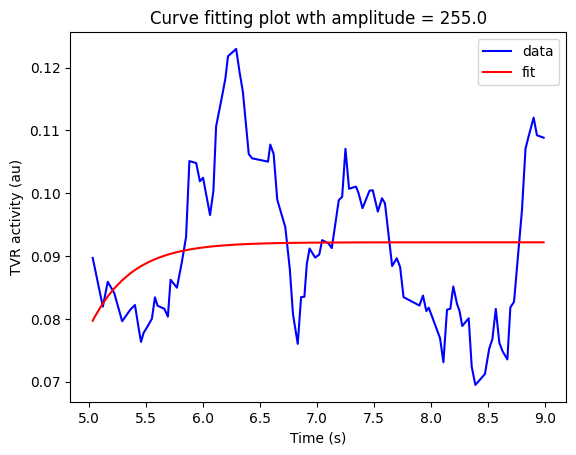

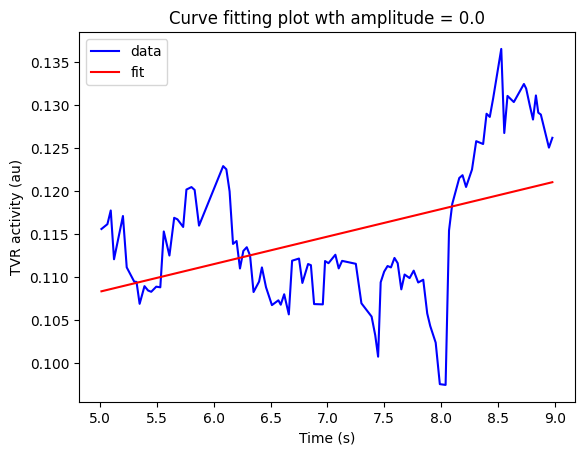

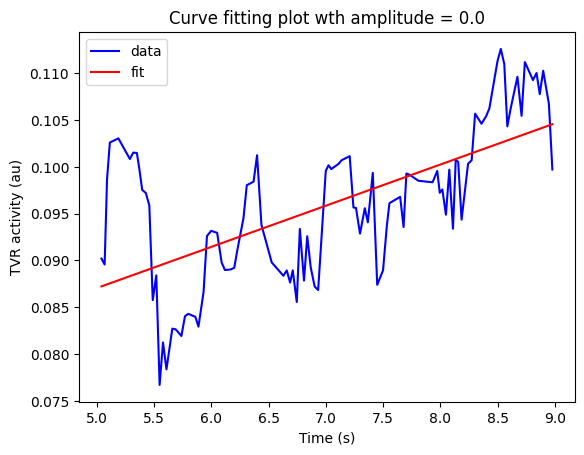

Now is processing:  /Users/xinyaoyo/MATLAB/Projects/UROP/Codes/single_subject_dataset/Pat0905_20_chan11


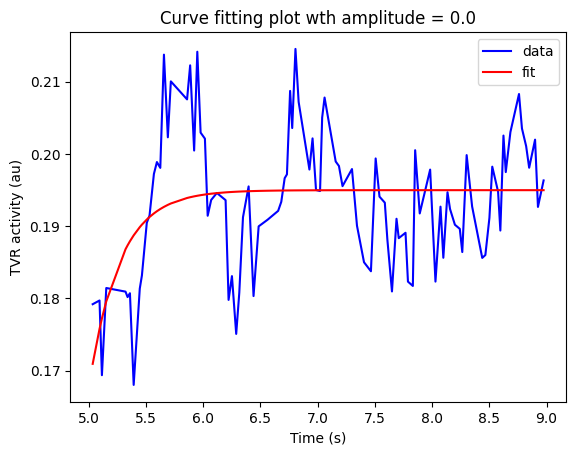

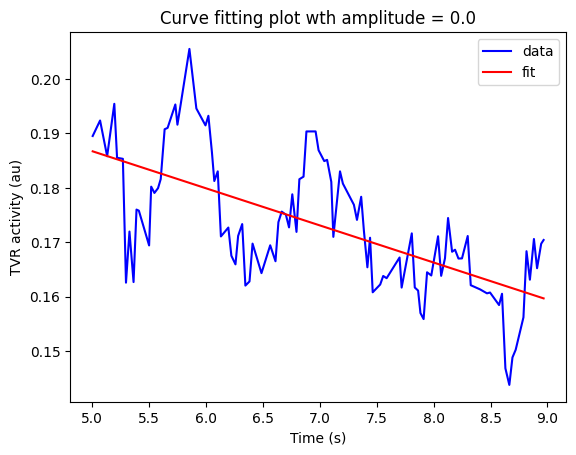

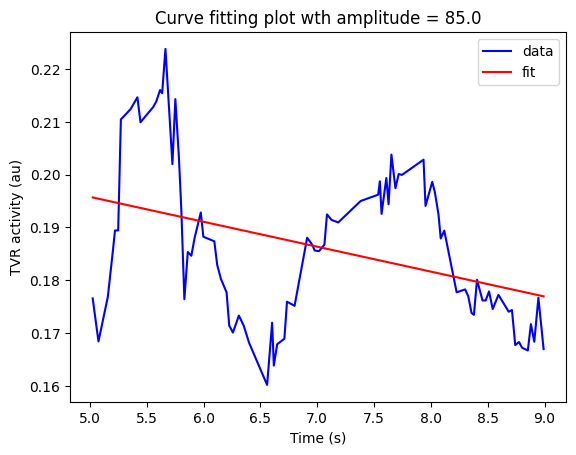

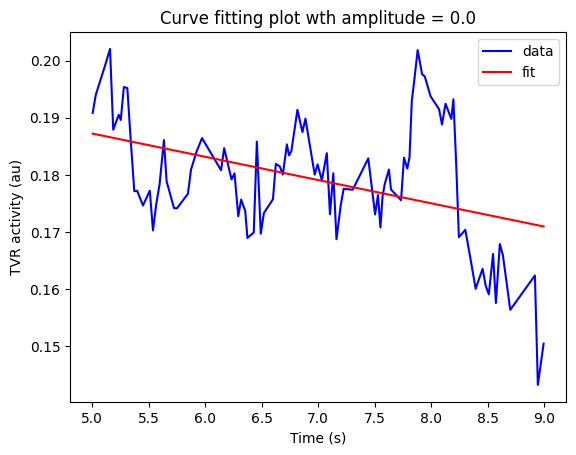

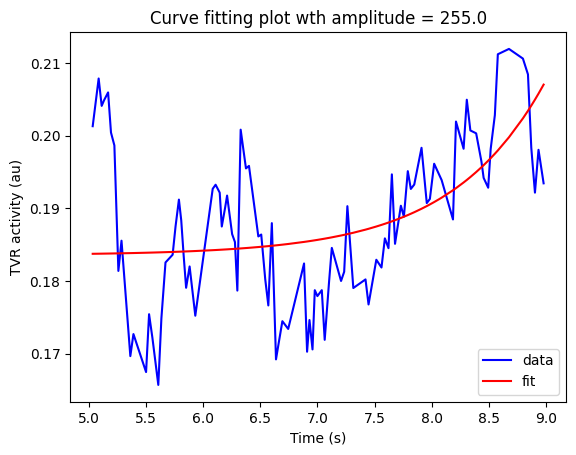

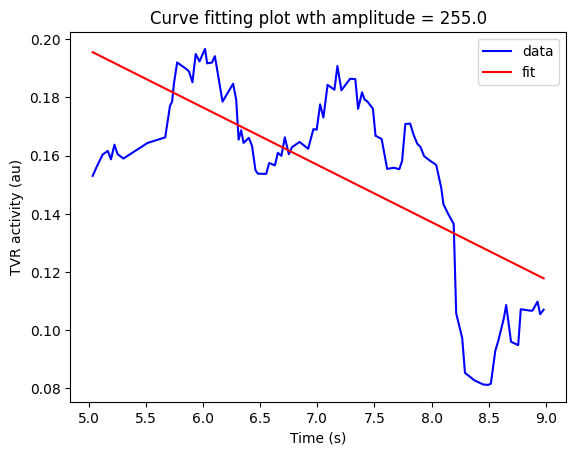

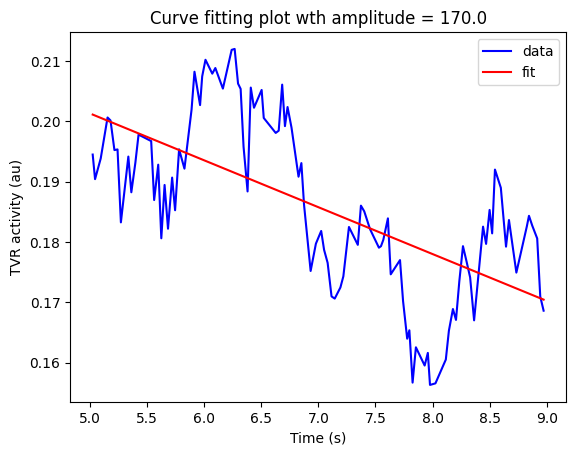

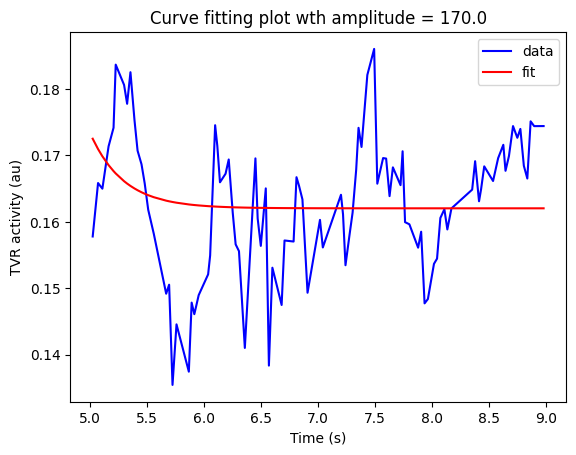

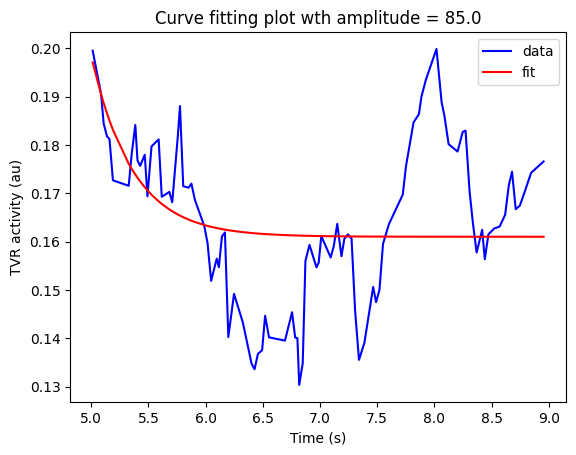

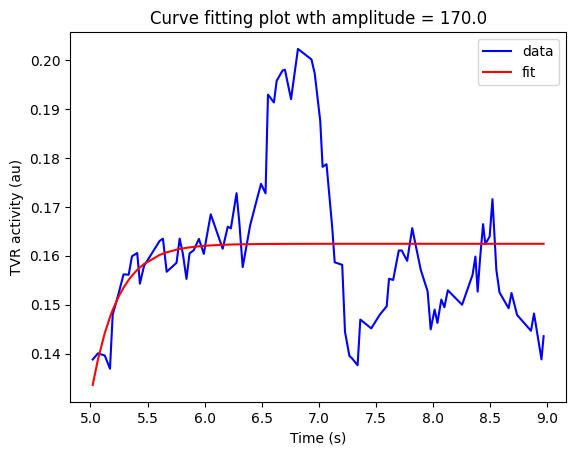

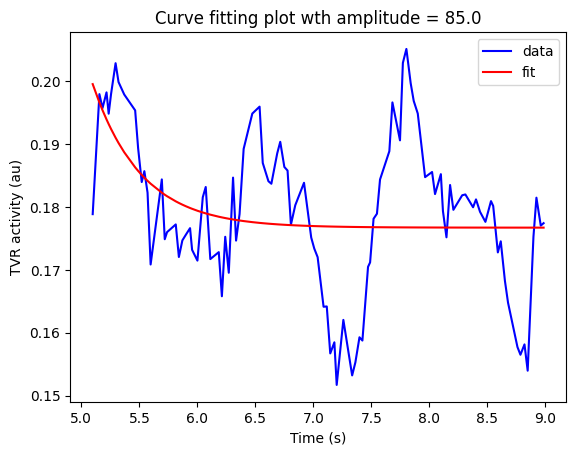

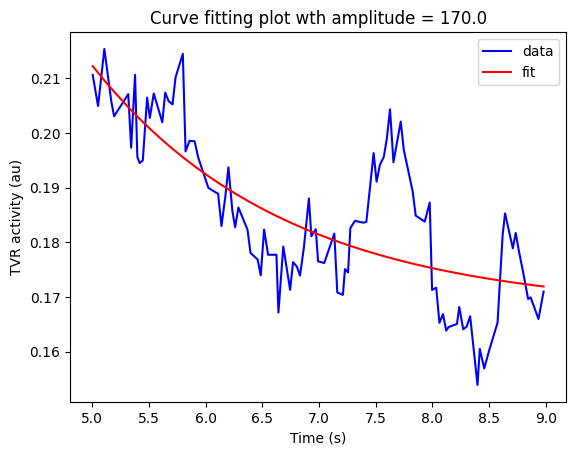

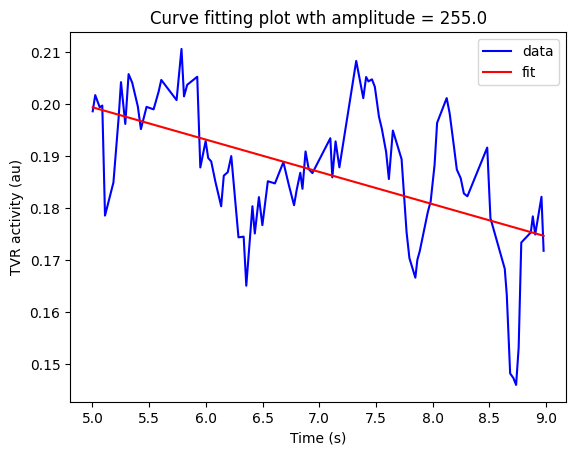

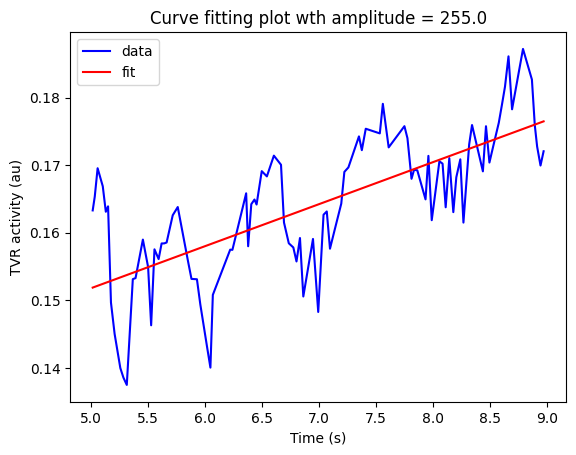

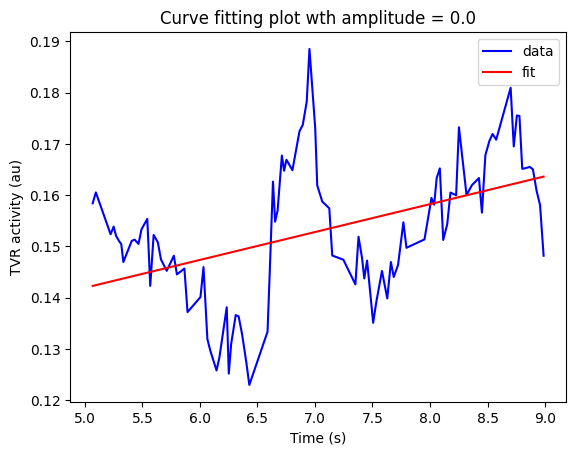

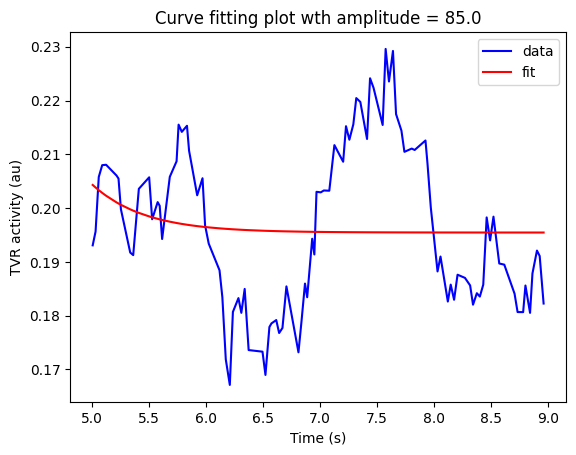

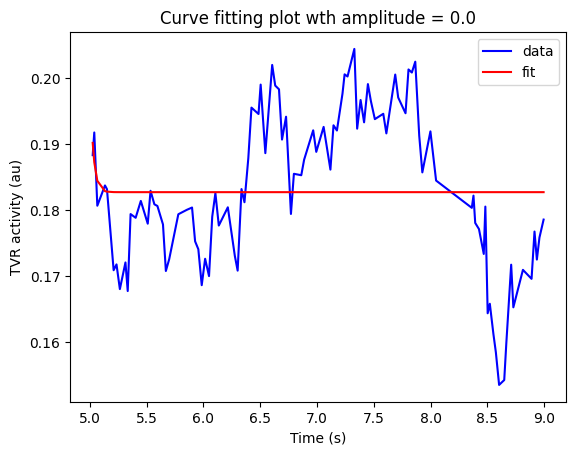

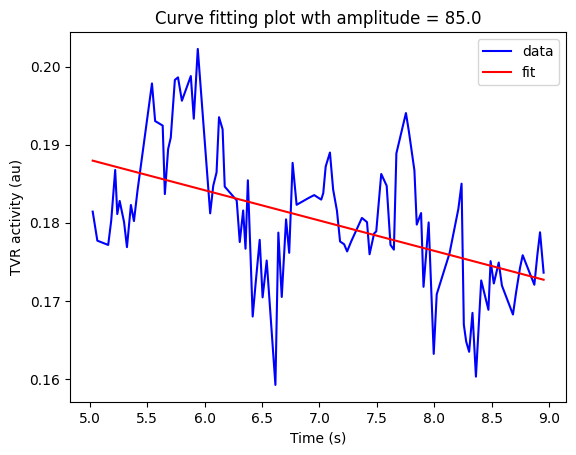

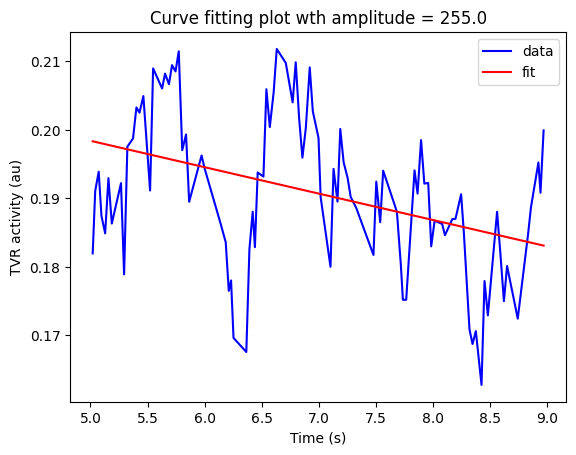

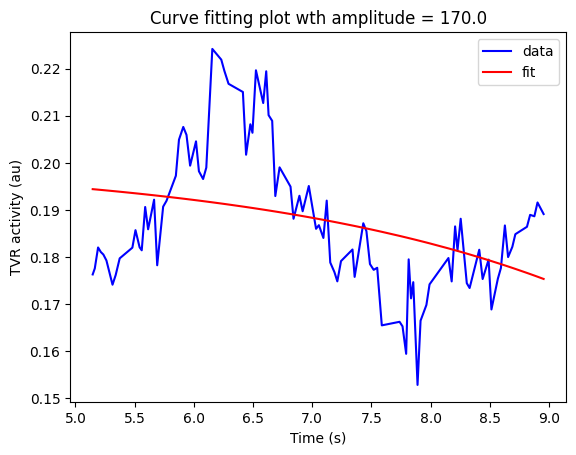

Now is processing:  /Users/xinyaoyo/MATLAB/Projects/UROP/Codes/single_subject_dataset/Pat0808_10_chan10


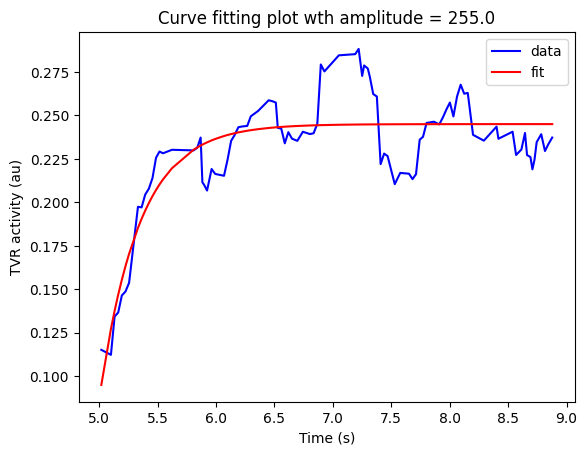

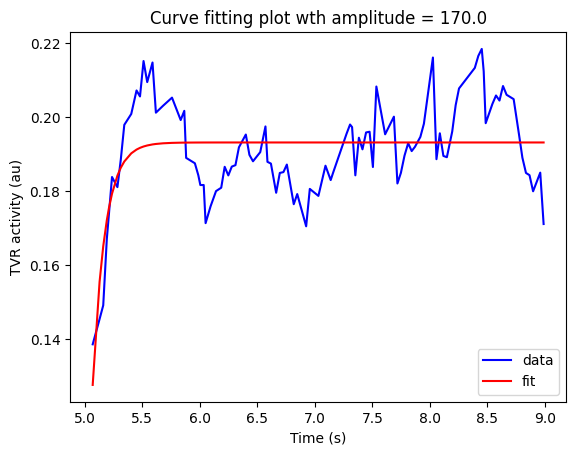

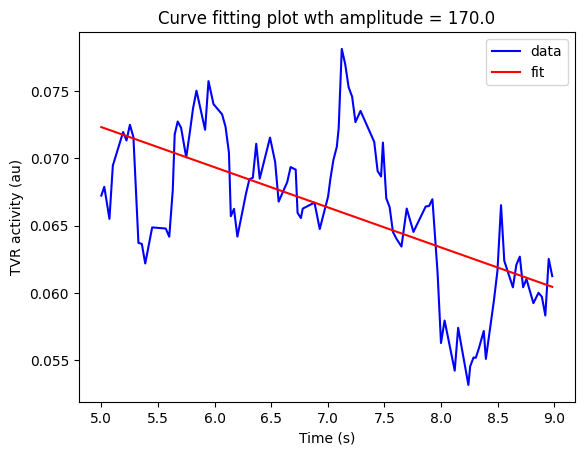

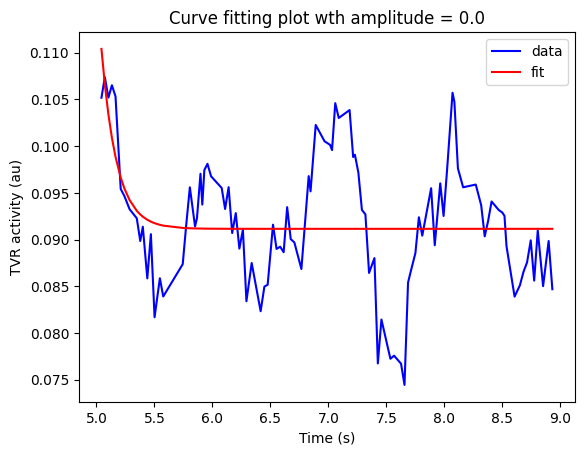

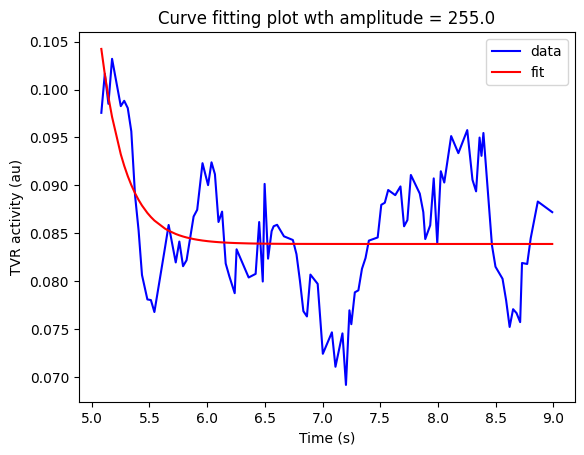

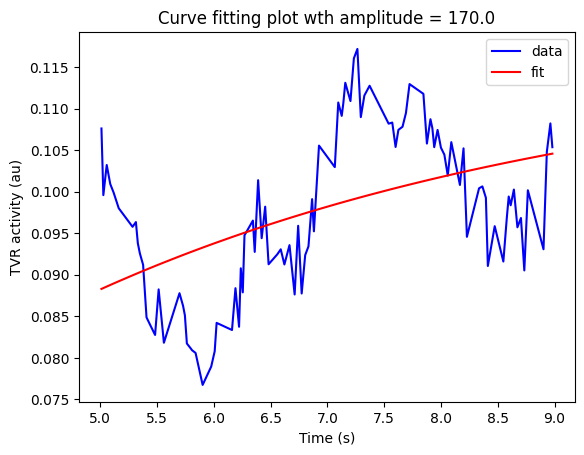

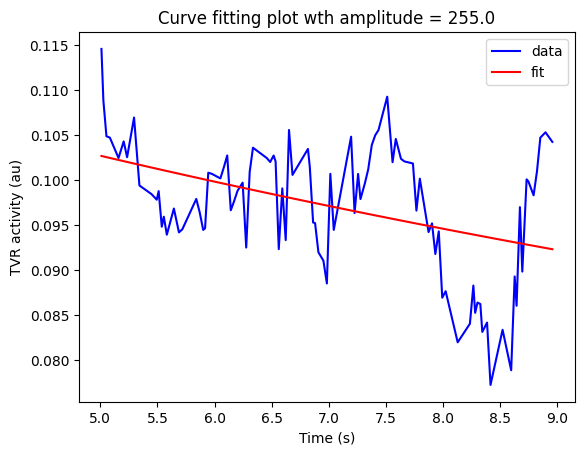

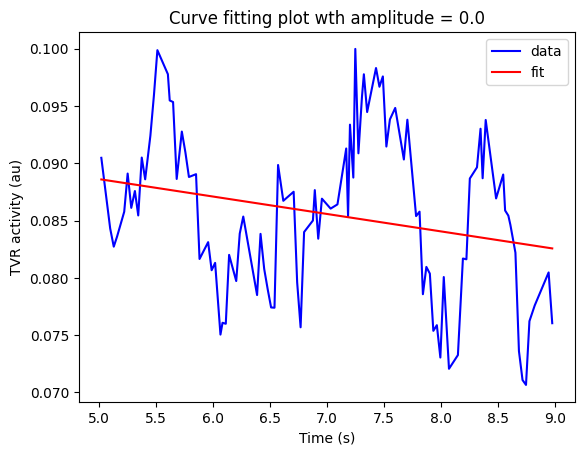

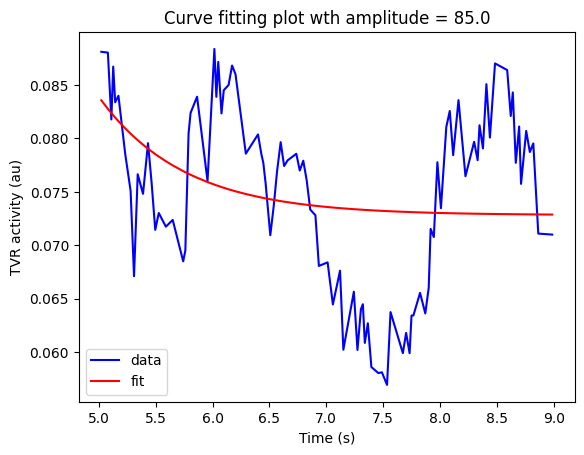

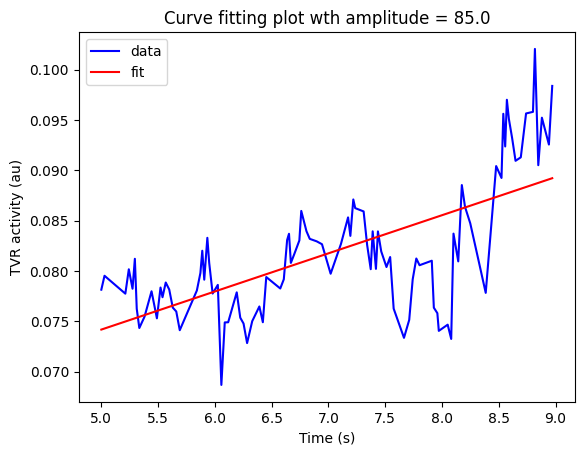

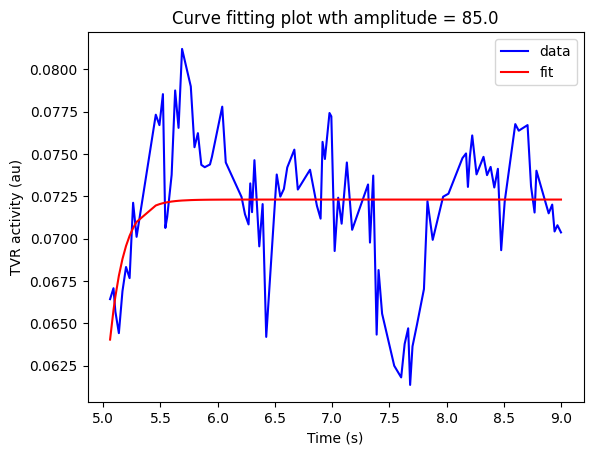

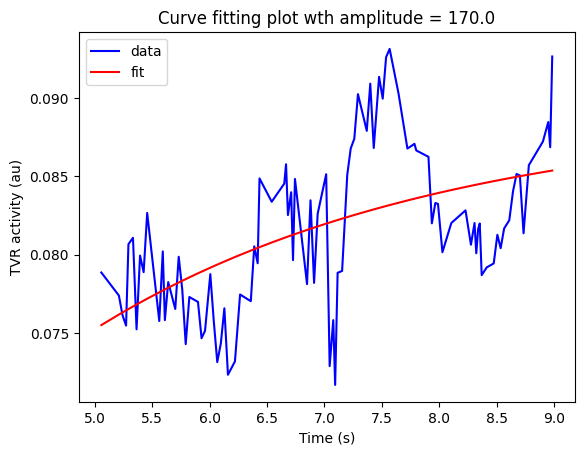

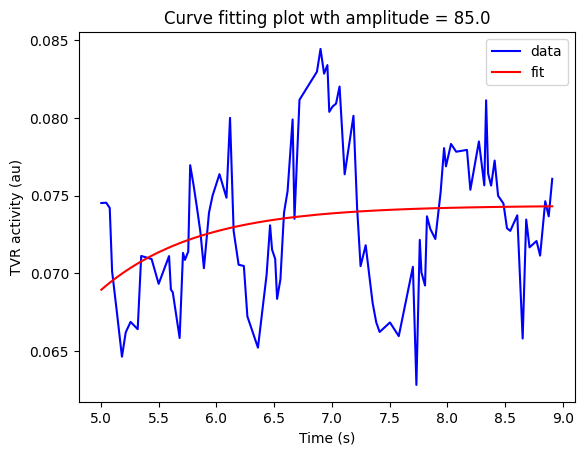

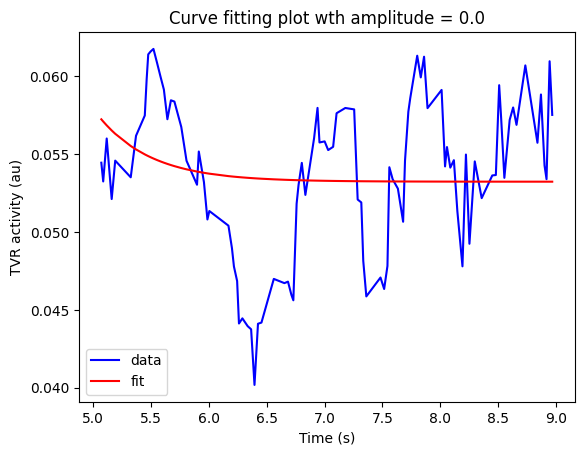

Now is processing:  /Users/xinyaoyo/MATLAB/Projects/UROP/Codes/single_subject_dataset/pat1130_20_chan4


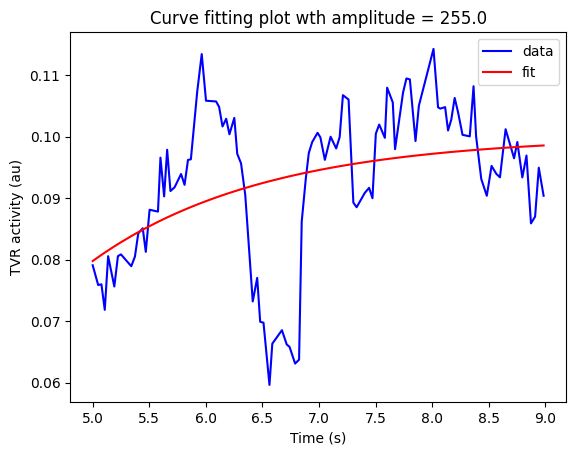

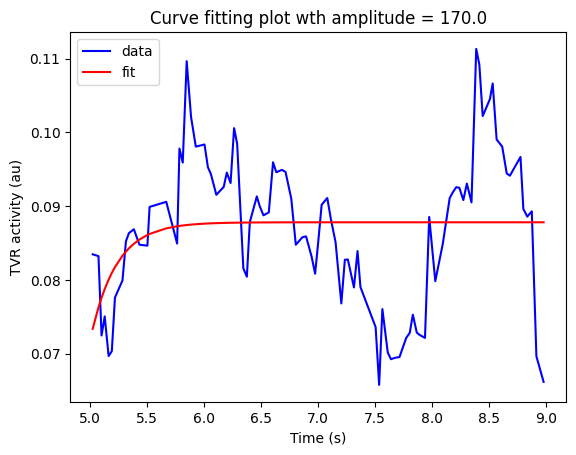

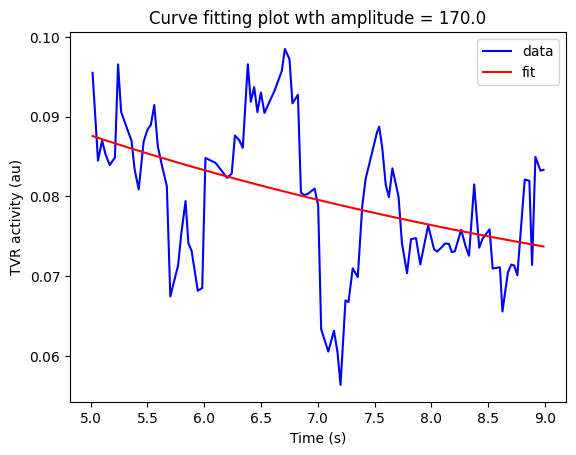

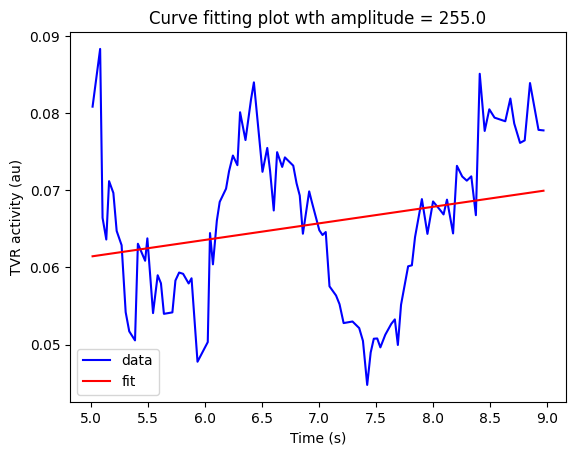

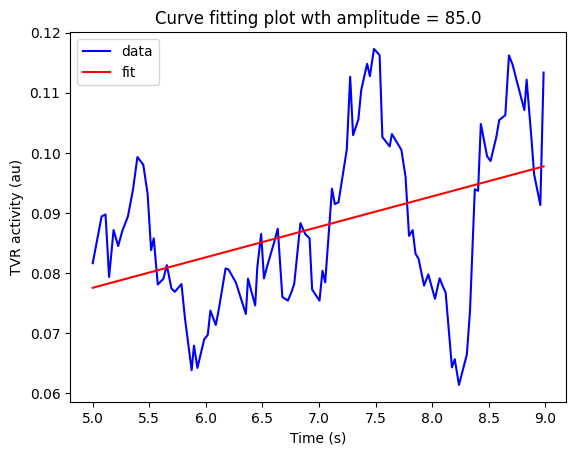

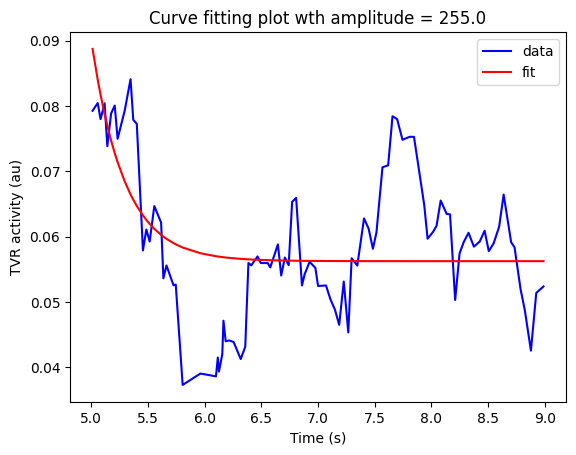

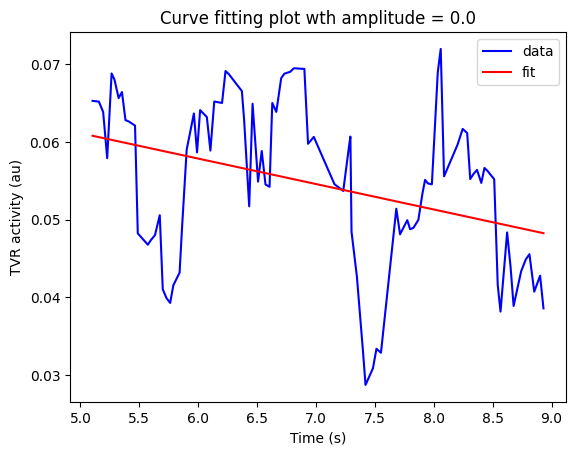

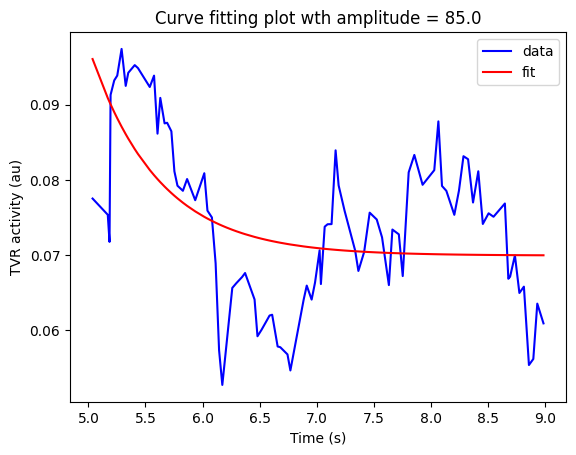

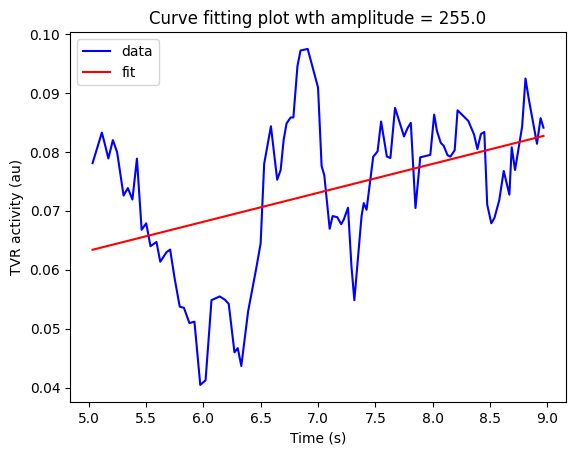

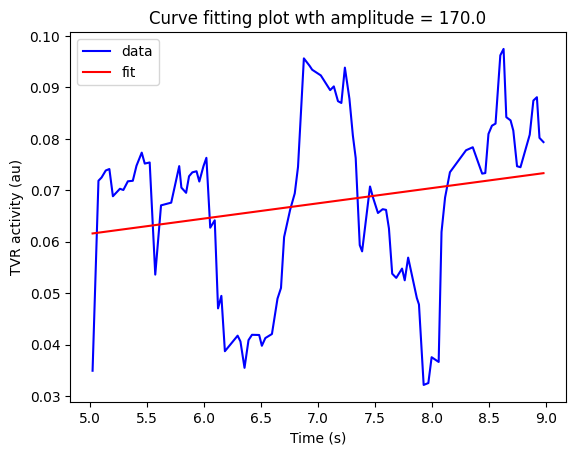

/var/folders/ps/tyv6x56x3hgc6qlpjh_n2lcc0000gn/T/ipykernel_98649/4091510462.py:3: RuntimeWarning: overflow encountered in exp
  return a * (1 - np.exp(-x / b)) + c
/Users/xinyaoyo/miniforge3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


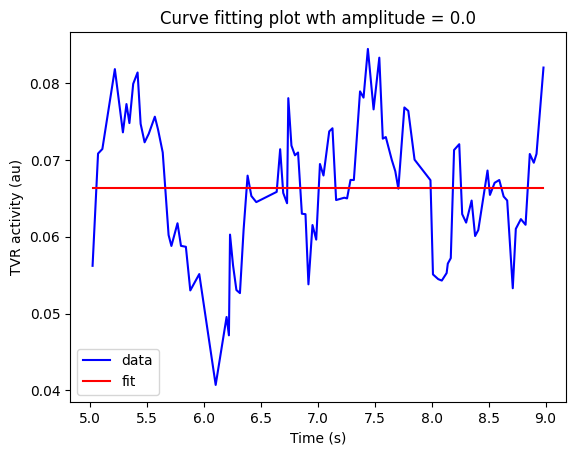

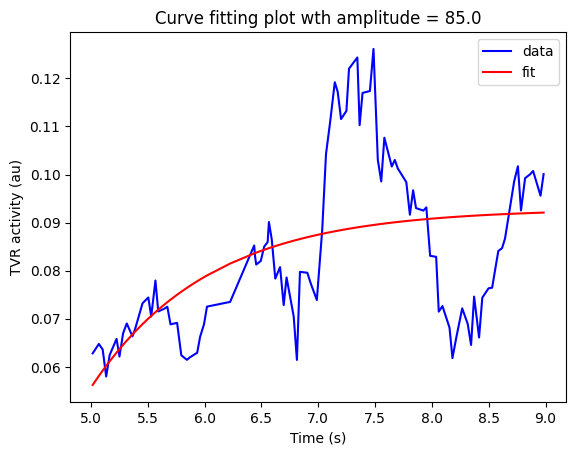

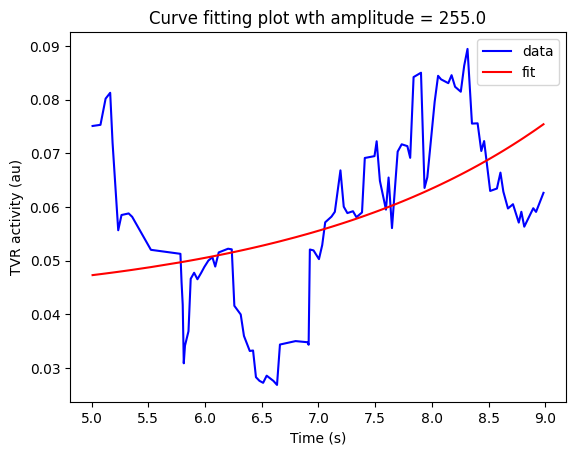

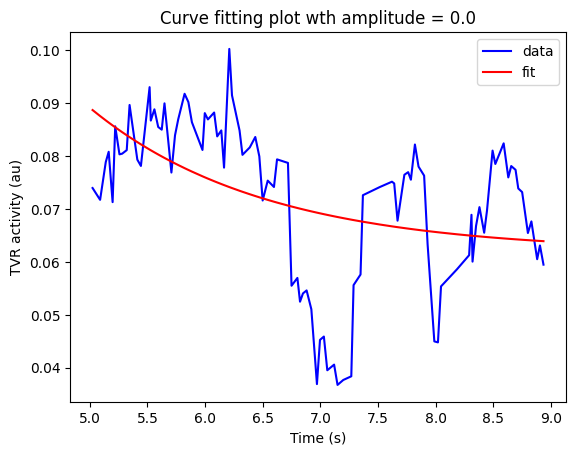

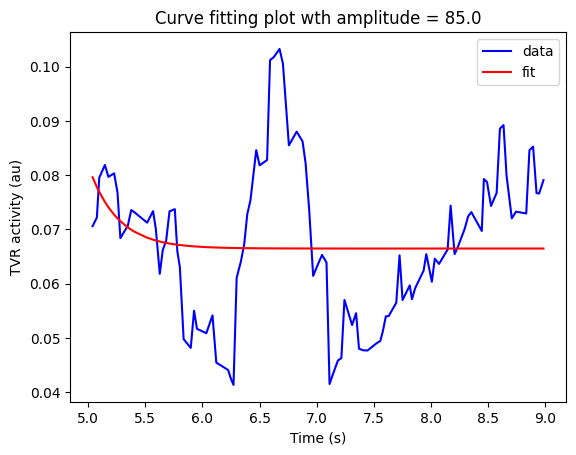

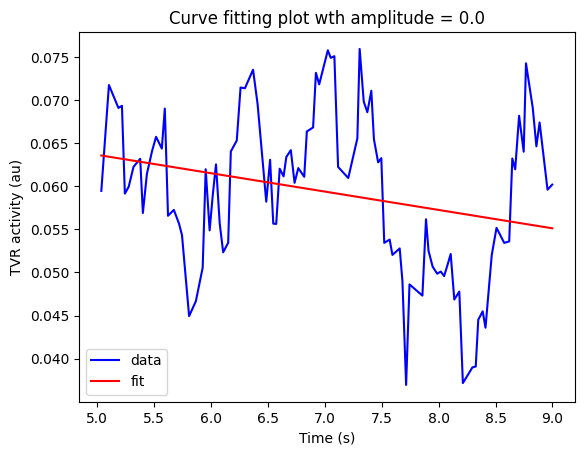

Now is processing:  /Users/xinyaoyo/MATLAB/Projects/UROP/Codes/single_subject_dataset/pat1130_00_chan4


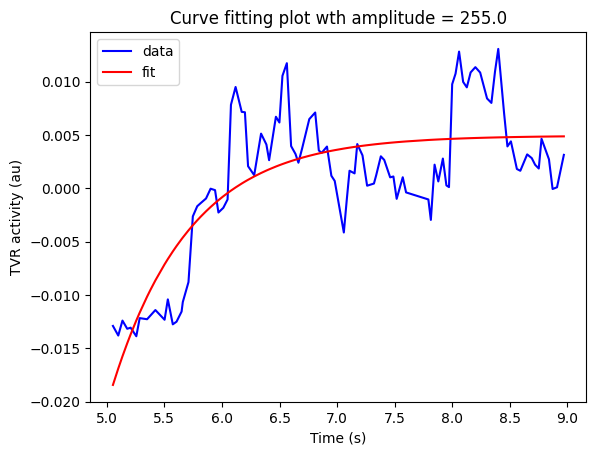

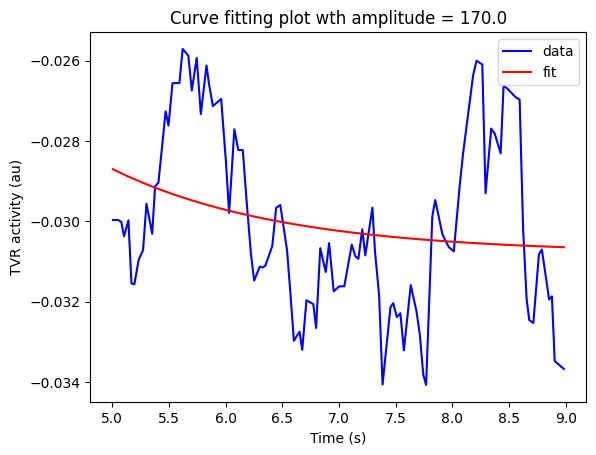

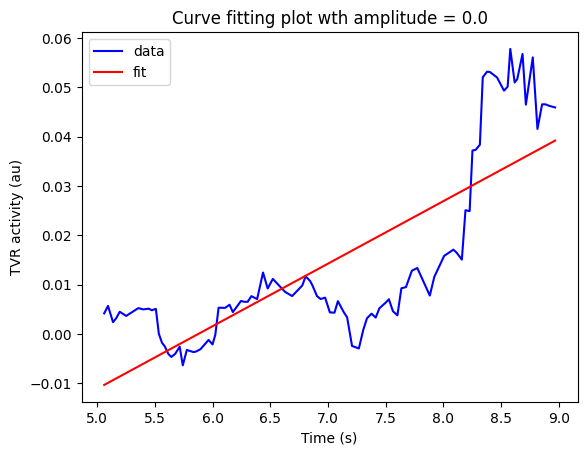

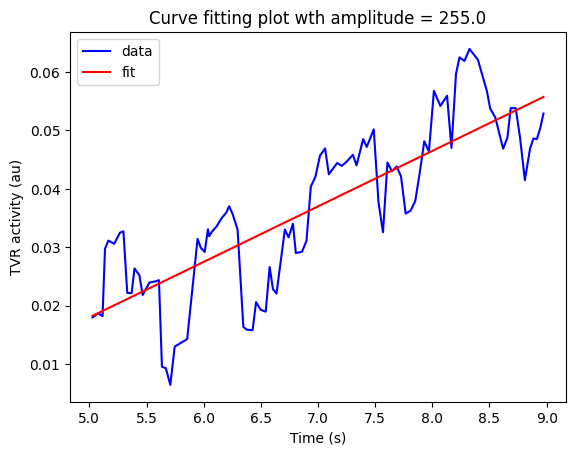

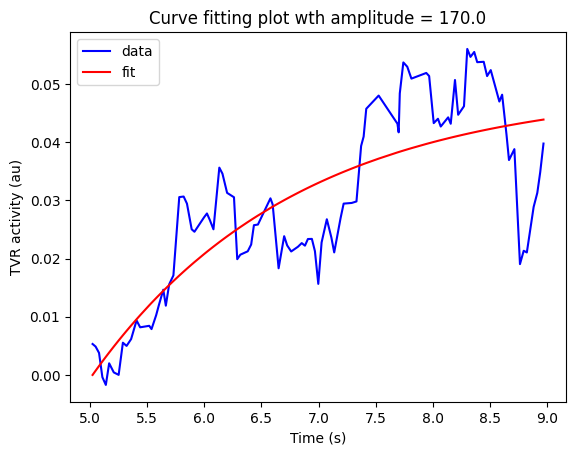

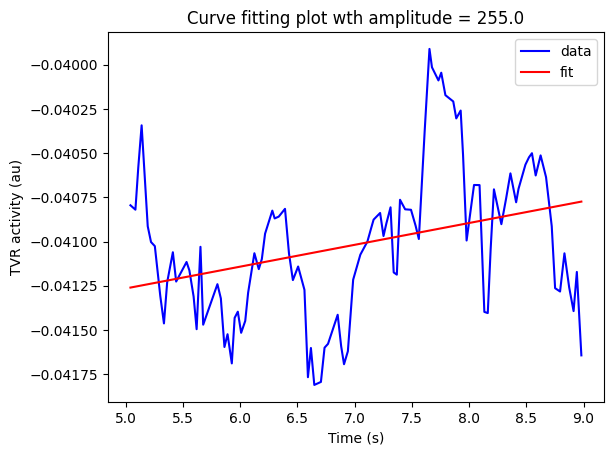

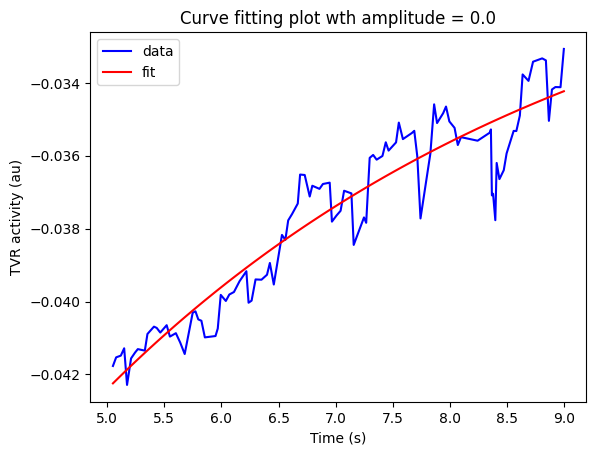

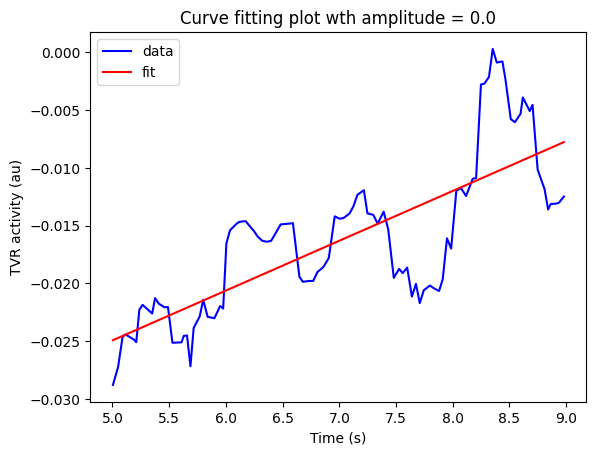

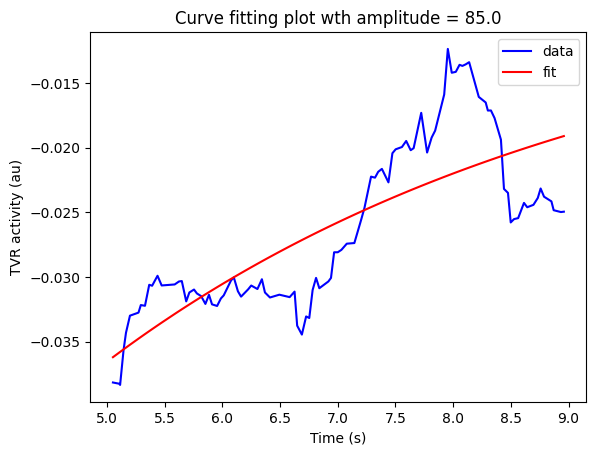

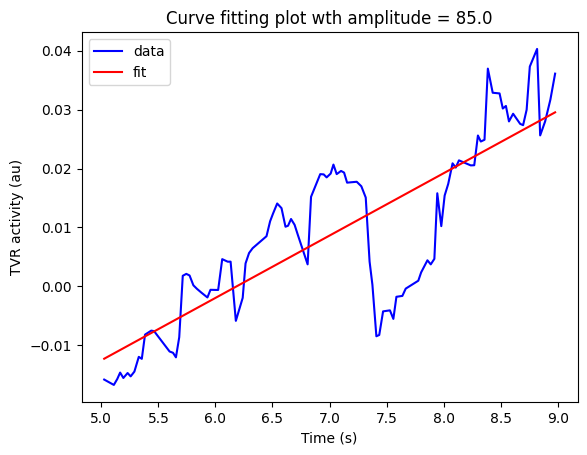

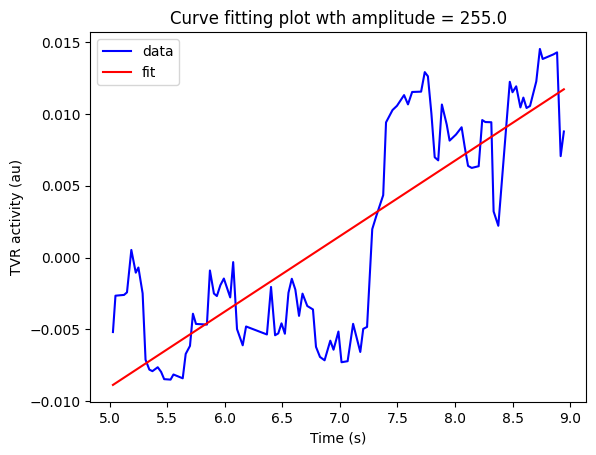

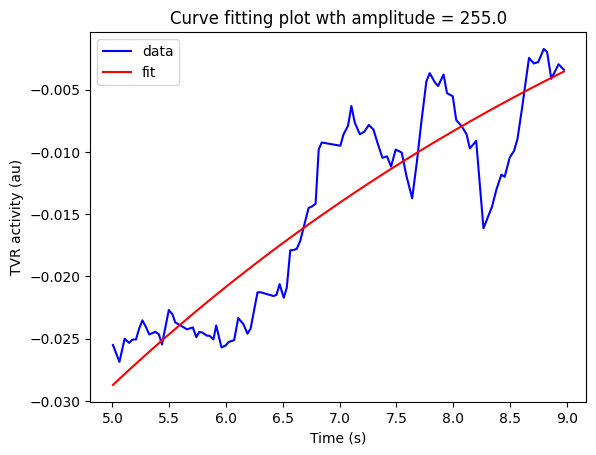

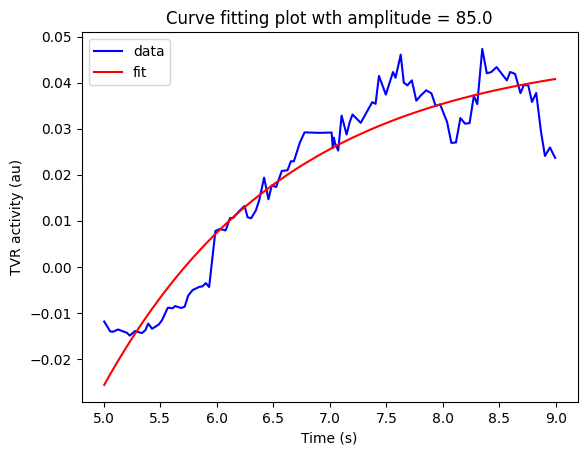

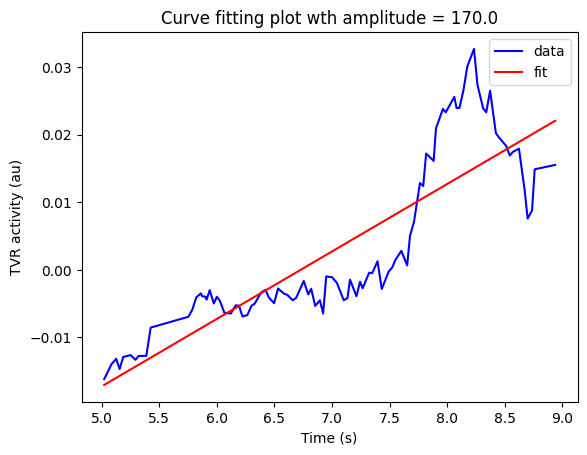

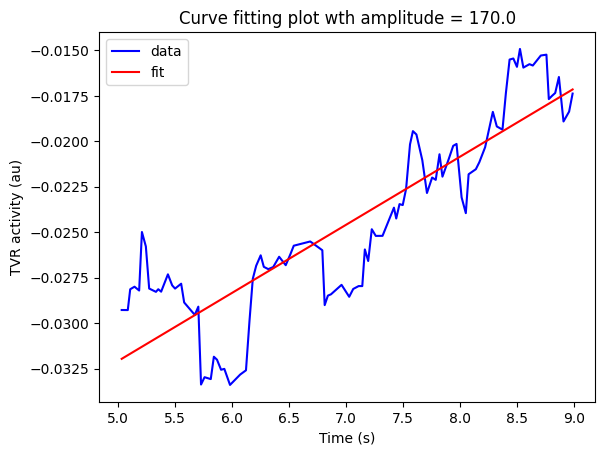

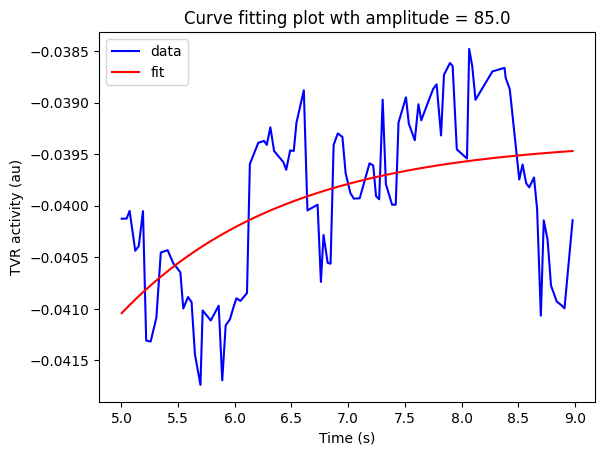

Now is processing:  /Users/xinyaoyo/MATLAB/Projects/UROP/Codes/single_subject_dataset/Pat0808_00_chan10


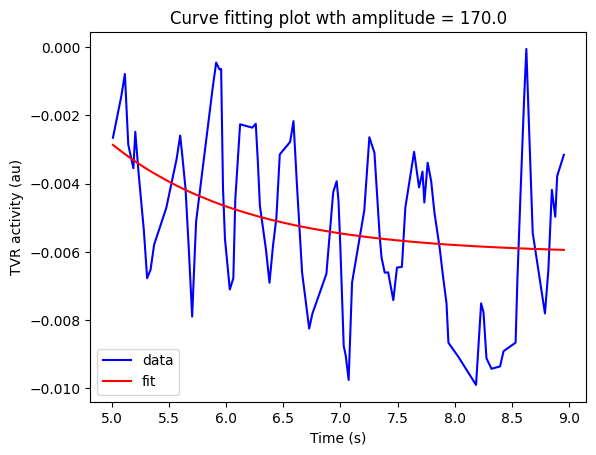

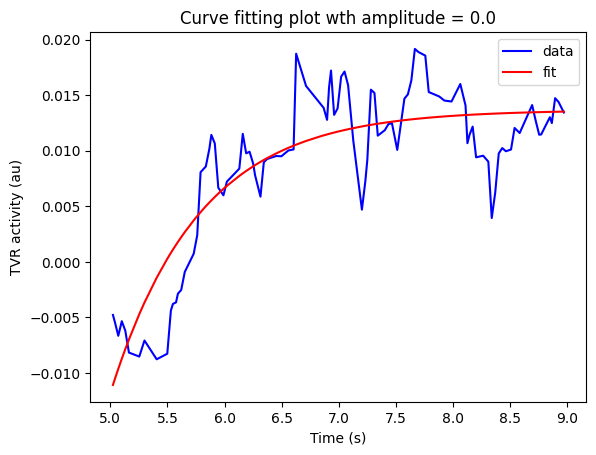

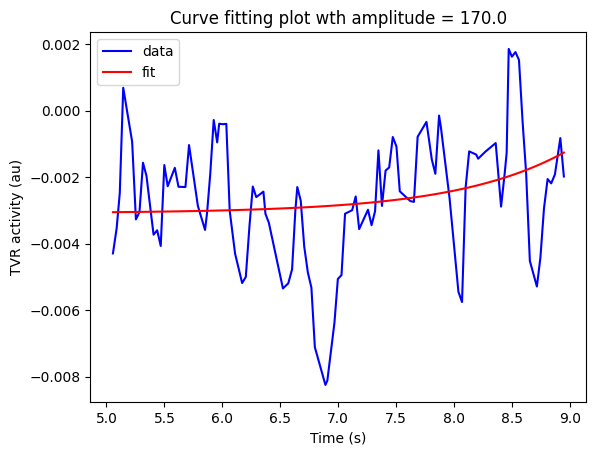

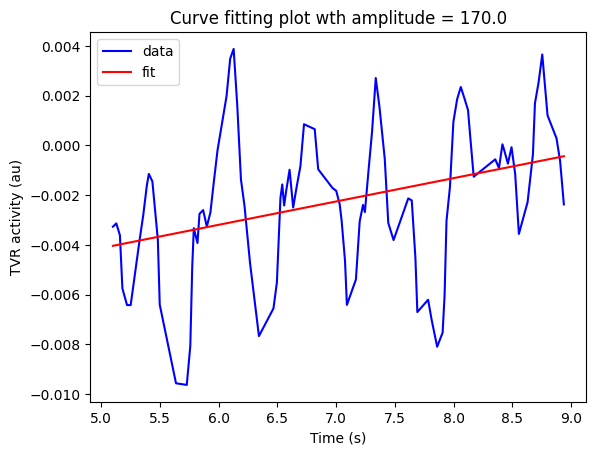

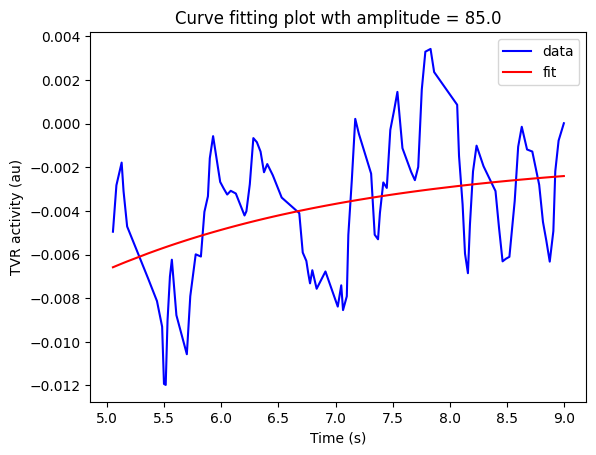

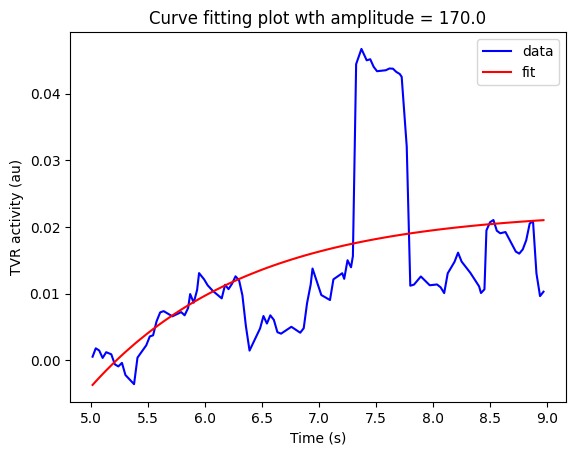

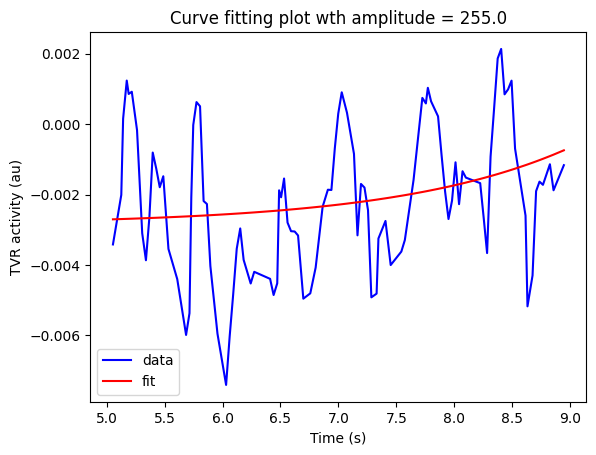

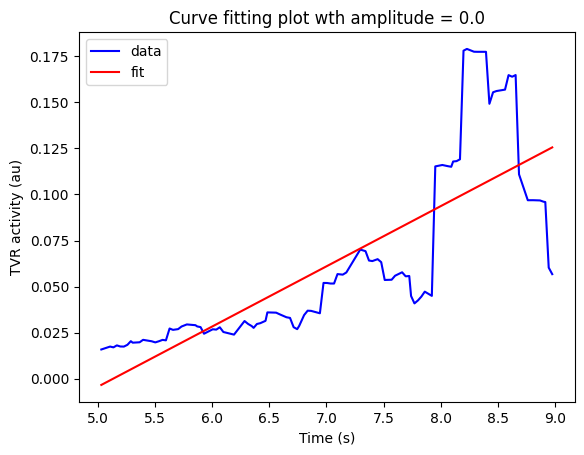

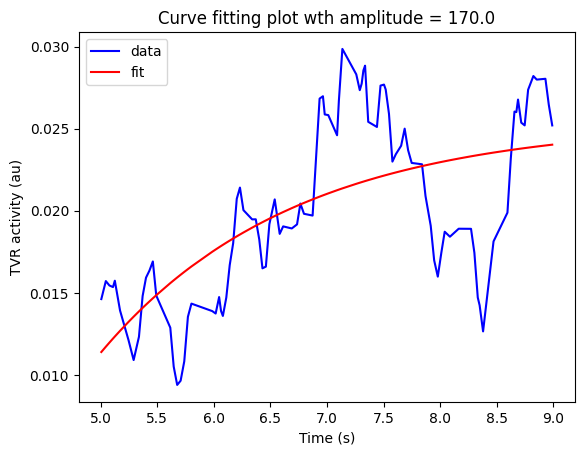

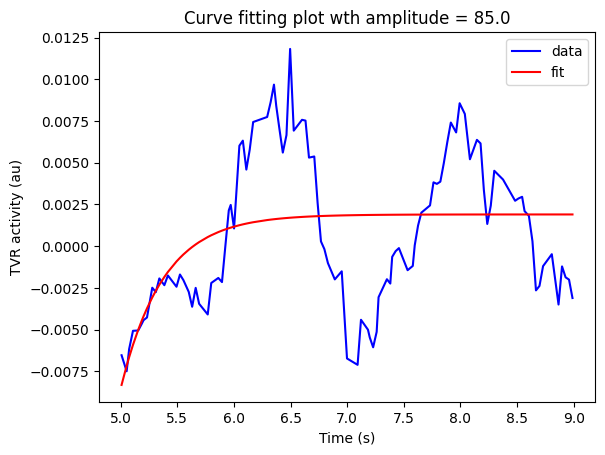

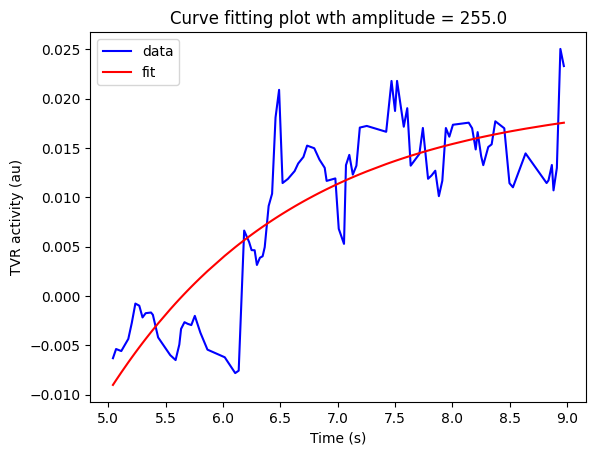

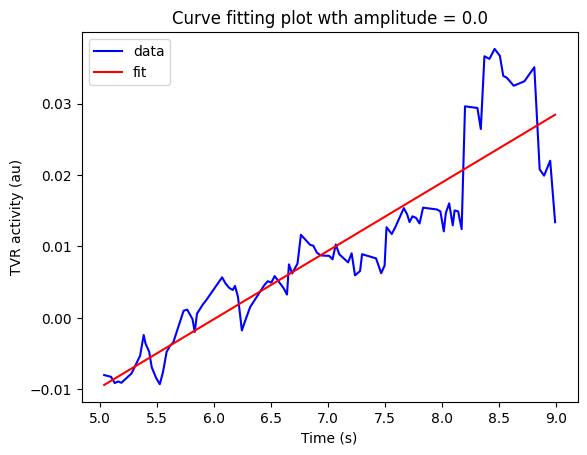

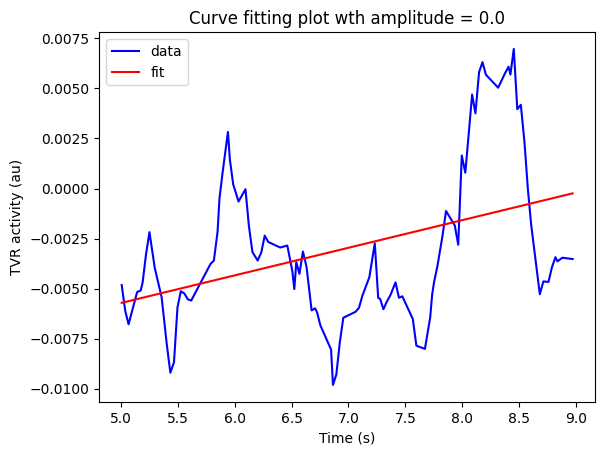

(8, 3)
(8,)


In [56]:
import glob
from scipy.signal import iirnotch, filtfilt
# Create empty lists to store the features and labels
features = []
labels = []
amplitudes = []
baselines = []
gradients = []
MVC_percentages = []
extension = '.bin'
file_pattern = '_QUAT.mat'

# Define the time points to extract data from
baseline_time = 2.0
gradient_start_time = 4.0
gradient_end_time = 6.0
output_time = 9.0

# Loop over files in folder
folder_path = "/Users/xinyaoyo/MATLAB/Projects/UROP/Codes/single_subject_dataset"
for subfolder_name in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder_name)
    # Ask the optimal channel
    channel = None
    while channel is None:
        print('Now is processing: ', subfolder_path)
        channel_str = input("Enter the optimal channel: ")
        MVC_string = input("Enter the %MVC: ")
        try:
            channel = int(channel_str)
            MVC_percentage = int(MVC_string)
            if channel < 1 or channel > 16:
                raise ValueError()
        except ValueError:
            print("Invalid channel. Please enter a number between 1 and 16.")
            channel = None

    channel -= 1

    if os.path.isdir(subfolder_path):
        # Get a list of sorted file names
        #sorted_files = sorted([f for f in os.listdir(subfolder_path) if f.endswith(extension)])
        to_scan = subfolder_path + '/*_QUAT*.mat'
        sorted_files = sorted(glob.glob(to_scan))
        # Load the additional data from the *.mat file
        with h5py.File(os.path.join(subfolder_path, sorted_files[0][:-3] + 'mat'), 'r') as f:
        # Get the trial stimulation amplitudes for all files
            #for key in f.keys():
                #print(key)
            vib_amps = f['RecInfo']['Experiment']['Order'][:]

        # Loop over the sorted file names and load the raw EMG from the BIN file
        for nfile, file_name in enumerate(sorted_files):
            # Input 1 - stimulation amplitude for the current file
            with h5py.File(os.path.join(subfolder_path, file_name[:-3] + 'mat'), 'r') as f:
                if nfile == 1:
                    vib_amp = vib_amps[0]
                else:
                    vib_amp = vib_amps[nfile-1]
                amplitude = vib_amp.item()
                # Get the TimeStamp data
                Time_Stamps = f['RecInfo']['Data']['TimeStamp'][:]
                # Remove the time offset
                Time = Time_Stamps - np.ones(len(Time_Stamps)) * Time_Stamps[0, 0]

                # Get EMVC
                EMVC = f['RecInfo']['Calibration']['EMVC'][:]

            # Load the raw EMG from the BIN file
            bin_name = file_name[:-3] + 'bin'
            with open(os.path.join(subfolder_path, bin_name), 'rb') as f:
                raw_emg = np.fromfile(f, dtype=np.int16)
                raw_emg = raw_emg.reshape(-1, 16).T
                
                # Filter noise 
                qfactor = 10
                fe = 116  # Assign peak frequency
                n_harmonics = 2
                fs = 1000  # system at 1k hz

                if fe > 0:
                    frequencies = np.arange(1, n_harmonics + 1) * fe
                    for freq_to_notch in frequencies:
                        wo = freq_to_notch / (fs / 2)
                        bw = wo / qfactor
                        b, a = iirnotch(wo, bw)
                        raw_emg = filtfilt(b, a, raw_emg)
                      
                # Filter noise *2
                qfactor = 10
                fe = 49  # Assign peak frequency
                n_harmonics = 2
                fs = 1000  # system at 1k hz

                if fe > 0:
                    frequencies = np.arange(1, n_harmonics + 1) * fe
                    for freq_to_notch in frequencies:
                        wo = freq_to_notch / (fs / 2)
                        bw = wo / qfactor
                        b, a = iirnotch(wo, bw)
                        raw_emg = filtfilt(b, a, raw_emg)          
            
                # EMG raw data at the optimal channel
                rmsWindow = 500
                BufSize = 40
                nSamples = raw_emg.shape[1]
                nWindows = int((nSamples / BufSize) - (rmsWindow / BufSize)) #number of windows
                samplect = 0
                nChannels = 16
                rmsEMG = np.zeros(nWindows) #number of channels - 16 - rmsEMG array size

                for n in range(1, nWindows + 1):
                    if n == 1:
                        DataI = raw_emg[channel, :rmsWindow]
                    else:
                        start_idx = (n - 1) * BufSize + 1
                        end_idx = start_idx + rmsWindow - 1
                        DataI = raw_emg[channel, start_idx:end_idx]
                    rmsEMG[samplect] = np.sqrt(np.mean(np.square(DataI)))
                    samplect += 1

                # Normalise data
                Data = np.zeros(nWindows)
                for i in range(nWindows):
                    Data [i] = (rmsEMG[i] - EMVC[channel, 1]) / (EMVC[channel, 0] - EMVC[channel, 1])

                # Input 2 - baseline data (normalized EMG data average between 1s and 2s)
                Time_shape = Time.shape
                Data_shape = Data.shape
                length = min(Time_shape[1], Data_shape[0])
                Time_slice = Time[:, :length]
                Data_slice = Data[:length]
                Time_bcast = Time_slice.reshape(length, 1)
                Data_bcast = Data_slice.reshape(-1, 1)
                pairs = np.hstack((Time_bcast, Data_bcast))
                indices = np.where((pairs[:, 0] >= 0.1) & (pairs[:, 0] <= 4.5))[0]
                baseline_data_set = pairs[indices, 1]
                baseline_data = np.mean(baseline_data_set)

                # Input 3 - gradient between 5s and 10s - use delta EMG instead as more accurate
                indices_after_stimulation = np.where((pairs[:, 0] >= 9) & (pairs[:, 0] <= 10))[0]
                after_stimulation_data_set = pairs[indices_after_stimulation, 1]
                after_stimulation_data = np.mean(after_stimulation_data_set)
                """
                extracted_data = pairs[(pairs[:, 0] >= 4) & (pairs[:, 0] <= 6)]
                emg_data_for_gradient = extracted_data[:, 1]
                time_values_for_gradient = extracted_data[:, 0]
                reg = LinearRegression().fit(time_values_for_gradient.reshape(-1, 1), emg_data_for_gradient)
                """
                gradient = (after_stimulation_data - baseline_data)/5

                # Fit the transfer function to the data and append the output
                # Define the threshold for the covariance matrix
                cov_threshold = 0.7 #tunable

                extracted_plateau = pairs[(pairs[:, 0] >= 5) & (pairs[:, 0] <= 9)]
                emg_data_for_transfer = extracted_plateau[:, 1]
                time_values_for_transfer = extracted_plateau[:, 0]
                time_values_shifted = time_values_for_transfer - 5

                try:
                    popt, pcov = curve_fit(transfer_function, time_values_shifted, emg_data_for_transfer, maxfev=800) #change potential function
                except RuntimeError:
                    print("Discarded.")
                """
                if np.all(np.diag(pcov) > cov_threshold):
                    # peak activity output at 9s
                    a_opt = popt[0]
                    b_opt = popt[1]
                    peak_value = transfer_function(9, a_opt, b_opt)
                else:
                    continue
                """
                # check the data and the fitted function
                import matplotlib.pyplot as plt
                plt.plot(time_values_for_transfer, emg_data_for_transfer, 'b-', label='data')
                plt.plot(time_values_for_transfer, transfer_function(time_values_for_transfer-5, *popt), 'r-', label='fit')
                plt.legend()
                plt.title("Curve fitting plot wth amplitude = {}".format(amplitude))
                plt.xlabel("Time (s)")
                plt.ylabel("TVR activity (au)")
                plt.show()

                a_opt = popt[0] # plateau activity
                b_opt = popt[1] # baseline activity at t = 5s
                c_opt = popt[2] # rate of increase
                peak_value = a_opt - b_opt #gompertz_function(9, a_opt, b_opt, c_opt)
                if peak_value >= 0:
                    labels.append(peak_value) #second label
                else:
                    continue

                # Append the input features to the corresponding lists
                features.append([amplitude, baseline_data, MVC_percentage])
                amplitudes.append(amplitude)
                baselines.append(baseline_data)
                gradients.append(gradient) # first label
                MVC_percentages.append(MVC_percentage)

# Convert the lists to numpy arrays
X = np.array(features, dtype=object)
z = np.array(gradients)
y = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape)
print(y_train.shape)

In [57]:
import csv
import numpy as np

# Define the file name and path
file_name = 'data.csv'
file_path = '/Users/xinyaoyo/MATLAB/Projects/UROP/Codes/Data_Jupyter'

# Combine the feature set and label set into one array
data = np.column_stack((X_train, y_train))
header = ['feature1', 'feature2', 'feature3', 'gradient']

# Save the data to a CSV file
with open(file_path + '/' + file_name, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(header)
    for row in data:
        row_str = [str(r) for r in row]
        writer.writerow(row_str)

In [58]:
from numpy import float64
# Method 2 - blood test - link: https://github.com/ritabratamaiti/Blooddonorprediction/blob/master/script.py
# Compare SVM, Perceptron, k-NN, Naive Bayes, and decision trees TPOTClassifier classification methods
import pandas as pd
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import KFold
from sklearn import tree
from tpot import TPOTClassifier


X = []
Y = []
list_clf = []

df = pd.read_csv('dataset.csv', na_values = {'?'})
df = df.values


X = df[:, :(df.shape[1]-1)]
Y = df[:, df.shape[1]-1]

tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2)
tpot.fit(X, Y)

#ignore this commented block, it's present only for a (now) obsolete test
'''
kf = KFold(n_splits=3)
kf.get_n_splits(X)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    clf.fit(X_test, Y_test)
    print(clf.score(X_train, Y_train))
'''
clf_tree = tree.DecisionTreeClassifier()
clf_svm = SVC()
clf_perceptron = Perceptron()
clf_KNN = KNeighborsClassifier()
clf_nb = BernoulliNB()

list_clf = [clf_tree, clf_svm, clf_perceptron, clf_KNN, clf_nb, tpot.fitted_pipeline_]

kf = KFold(n_splits=5)
kf.get_n_splits(X)
c = 1
for clfs in list_clf:
    print(c)
    c += 1
    a = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        clfs.fit(X_test, Y_test)
        print(clfs.score(X_train, Y_train))
        a += clfs.score(X_train, Y_train)
    a = a/5
    print("Average=",a,"\n")
    print(clfs,"\n")

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [59]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# Load the data from a CSV file
df = pd.read_csv('data.csv')

# Convert the %MVC column to categorical data type
df.iloc[:, 2] = df.iloc[:, 2].astype('category')
# Encode the categorical variable as binary variables
encoder = OneHotEncoder()
X_cat = encoder.fit_transform(df.iloc[:, [2]])

# Normalize the amplitude column
scaler = StandardScaler()
df.iloc[:, 0] = scaler.fit_transform(df.iloc[:, 0].values.reshape(-1, 1))

# Combine everything
X_cont = df.iloc[:, [0, 1]]
X = np.concatenate([X_cat.toarray(), X_cont], axis=1)

# Split the data into training and testing sets
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the feature and label sets to float
#X_normalized = X_normalized.astype(float)
#y = y.astype(float)

# Create the SVR model and fit it to the training data
#svr = svm.SVR(kernel='poly', degree=2)
#svr.fit(X_train, y_train)

# Train a random forest regression model on the data
#rf = RandomForestRegressor(n_estimators=100, random_state=42)
#rf.fit(X_train, y_train)

# Predict the target values for the test data
#y_pred = rf.predict(X_test)

from sklearn.neighbors import KNeighborsRegressor

# Train a KNN regression model on the data
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict the target values for the test data
y_pred = knn.predict(X_test)

# Calculate the mean squared error between the predicted and actual target values
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean squared error: {mse:.10f}')
print(f'r2_score: {r2:.10f}')
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are your actual and predicted values, respectively

import numpy as np
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are your actual and predicted values, respectively
trial_numbers = np.arange(len(y_test)) + 1  # Generating trial numbers

# Set the width of the bars
bar_width = 0.35

# Create an array for the x-axis positions
index = np.arange(len(y_test))

# Create the bar chart
plt.bar(index, y_test, bar_width, label='Actual Values', color='green')
plt.bar(index + bar_width, y_pred, bar_width, label='Predicted Values', color='orange')

# Set labels and title
plt.xlabel('Trial Number')
plt.ylabel('Activity Level')
plt.title('Actual vs Predicted Values by Trial')
plt.xticks(index + bar_width / 2, trial_numbers)
plt.legend()

# Show the chart
plt.show()


Mean squared error: 19372063.4591512345
r2_score: -46378925.1084984317
